# Etapa 01: Preprocessamento

Adaptação do código que realiza o preprocessamento das TAGs, antes de definir os modelos
preditivos.

Este notebook é uma adaptação do código de preprocessamento da usina 8, utilizando
os códigos originais, que foram refatorados em uma biblioteca Python, chamada `pelopt`.

## Refatoração

Todos os códigos foram refatorados de modo a permitir que o código seja
utilizado para preprocessar os dados das demais usinas. Ao invés de utilizar
nomes de maneira "hard coded", todas as tags foram reescritas utilizando
a variável `n_usina` como usina sendo processada.


## Imports Necessários

### Imports Externos

In [7]:
from __future__ import annotations

import re
from pathlib import Path
from typing import Dict, List

import joblib
import numpy as np
import pandas as pd


### Imports Locais

In [8]:
from pelopt.tags import tagpims, tagOTM, taglab, tag_calc
from pelopt.usina.calc_tags import get_calculated_tags
from pelopt.usina.datasets_limits import LIMITS as limits
from pelopt.usina.datasets_confs import DATASETS_CONFS as datasets_confs
from pelopt.utils.logging_config import logger
from pelopt.utils.utils import add_model_tags

## Parâmetros de Execução

Definindo os parâmetros de execução. Estes parâmetros serão utilizados em diversos
momentos, durante a execução.

In [9]:
n_usina = 8
us_sufix = f'{n_usina:02d}'
solver_path = f'us{n_usina:1d}'

faixamin = 700
faixamax = 1000
step = 50

df_faixa = pd.DataFrame(
    {
        'faixaMin': list(range(faixamin, faixamax, step)),
         'faixaMax': list(range(faixamin + step, faixamax + step, step)),
    }
)

## Unificando Lista de Tags

Existem **4 listas de tags** que iremos utilizar durante o preprocessamento: `tagpims`, `tagOTM`, `taglab` e `tag_calc`.

As tags representam os diferentes sensores existentes ao longo do processo de pelotização.

In [10]:
tag_calc = list(set(tag_calc) - set([*tagpims, *tagOTM, *taglab]))

tagpims = tagpims + tagOTM + taglab + tag_calc

old_tag_count = len(tagpims)
tagpims = list(set(tagpims))
tag_count = len(tagpims)
diff_tag_count = old_tag_count - tag_count

if diff_tag_count > 0:
    logger.warning('Duplicate tags found inside `tagpims`: %s duplicate tags',
                   f'{diff_tag_count:,}')

[2023-01-16 23:32:07,847 | WARNING | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/3245625978.py:3245625978:11] - Duplicate tags found inside `tagpims`: 74 duplicate tags


In [11]:
def find_file(
    base_dir: str | Path | None = None,
    filename: str | Path | None = None,
    suffix: str | None = None,
    recursive: bool = True,
    max_upper_dirs: int | None = 2,
) -> List[str]:
    """
    Find filepaths matching a given name or suffix in a directory.

    Function tries to find filepaths that match :param:`filename`, or that
    contain :param:`filename` in its name. When no :param:`filename` is
    specified, function will find filepaths that contain the suffix
    specified by :param:`suffix`.

    Parameters
    ----------
    base_dir : str | Path | None
        The directory to search in. Default is the current working directory.
    filename : str | Path | None
        The name of the file to search for. This parameter is obligatory, when
        :param:`suffix` is equal to None.
    suffix : str | None
        The file suffix to search for. This parameter is obligatory, when
        :param:`filename` is equal to None.
    recursive : bool, default=True
            Search recursively through the directory and its subdirectories.
    max_upper_dirs : int | None, default=2
        The maximum number of parent directories to search in. This parameter
        only gets used when :param:`recursive` is set to True.

    Returns
    -------
    List[str]
        List of file paths that match the search criteria.

    Raises
    ------
    ValueError
        When neither :param:`filename` nor :param:`suffix` is specified.
    FileNotFoundError
        When no filepath matches the specified criteria.

    Examples
    --------
    >>> find_file(filename='sr', recursive=False)
    ['/Users/erikingwersen/Documents/GitHub/peloptimize/src']
    >>> find_file(filename='datasets', suffix='.joblib')
    ['/Users/erikingwersen/Documents/GitHub/peloptimize/datasets.joblib',
     '/Users/erikingwersen/Documents/GitHub/peloptimize/tmp/us8/datasets.joblib']
    >>> find_file(suffix='.joblib')
    ['/Users/erikingwersen/Documents/GitHub/peloptimize/datasets.joblib',
     '/Users/erikingwersen/Documents/GitHub/peloptimize/tmp/us8/df_sql_raw.joblib',
     '/Users/erikingwersen/Documents/GitHub/peloptimize/tmp/us8/datasets.joblib',
     '/Users/erikingwersen/Documents/GitHub/peloptimize/tmp/us8/df_sql.joblib']
    >>> find_file()  # doctest: +ELLIPSIS
    Traceback (most recent call last):
    ...
    ValueError: Either `filename` or `suffix` must be specified.
    """
    base_dir = Path.cwd() if base_dir is None else Path(base_dir)
    if isinstance(suffix, str):
        suffix = suffix if suffix.startswith(".") else f".{suffix}"
    if filename is None and suffix is None:
        raise ValueError(
            "Either `filename`, `suffix`, or both must be specified."
        )
    if filename is None:
        filename = Path(suffix)
    else:
        filename = Path(filename)
        if isinstance(suffix, str):
            filename = filename.with_suffix(suffix)
    glob_pattern = ""
    current_dir = ""
    if recursive:
        glob_pattern = "**/"
    else:
        max_upper_dirs = 1
    while max_upper_dirs > 0:
        glob_patterns = [
            f"{current_dir}{glob_pattern}{filename}",
            f"{current_dir}{glob_pattern}*{filename}",
            f"{current_dir}{glob_pattern}*{filename}*",
            f"{current_dir}{glob_pattern}{filename}*",
        ]
        for glob in glob_patterns:
            matches = list(map(str, base_dir.glob(glob)))
            if len(matches) > 0:
                return matches
        current_dir = f"../{current_dir}"
        max_upper_dirs -= 1
    raise FileNotFoundError(
        f"Could not find {filename} in {base_dir} or any of its "
        f"parent directories."
    )


## Leitura dos Inputs

Código abaixo primeiro busca por um arquivo CSV chamado `'df_sql_original.csv'`,
dentro do mesmo diretório que este notebook. Caso este CSV não exista,
ele é criado a partir dos arquivos `'df_sql.csv'` e `'datasets.joblib'` que
precisam existir também no mesmo diretório que este notebook.

In [12]:
filepath = find_file(filename='df_sql_original.csv')[0]

if not Path(filepath).exists:
    logger.info('Transforming input file back into its original shape')
    datasets = joblib.load(find_file(filename='datasets.joblib')[0])
    df_base = datasets[list(datasets.keys())[0]]

    null_count = df_base.index.isnull().sum()
    new_index = pd.to_datetime(df_base.index, errors='coerce')
    new_null_count = new_index.isnull().sum()

    if new_null_count <= null_count:
        df_base.index = new_index

    df_sql = pd.read_csv(
        find_file(filename='df_sql.csv')[0], encoding='latin-1', parse_dates=True,
    ).loc[lambda xdf: xdf['PROD_PQ_Y@08US'] > 0, :]

    if df_base.shape[0] == df_sql.shape[0]:
        df_sql['data'] = df_base.index
    else:
        first_date = new_index.min()
        date_range = pd.date_range(
            start=first_date, periods=df_sql.shape[0], freq='H', tz='America/Sao_Paulo'
        )
        df_sql['data'] = date_range

    df_sql = df_sql.melt(
        id_vars=['data'],
        value_vars=df_sql.columns,
        var_name='variavel',
        value_name='valor',
    )
    df_sql.to_csv(filepath, index=False)


In [13]:
df_sql = (
    pd.read_csv(filepath, encoding='latin-1', parse_dates=True)
    .drop_duplicates(subset=['data', 'variavel'], keep='first')
    .pivot(index='data', columns='variavel', values='valor')
    .loc[lambda xdf: xdf['PROD_PQ_Y@08US'] > 0, :]
)
df_sql

variavel,%CF. ANT,10 - DIF PRODUTIVI EFETIVA - VIRTUAL - CALC - US8,=192/VELO,=PQ*24/768/FUNC,"ABRA_-0,5_PQ_L@08QU",CALC1_Y@08FI-FD00,CALC1_Y@08FI-FD00-L1,CALC1_Y@08FI-FD00-L2,CAO_OCS_I@08MO-CALCARIO,CARV1_OCS_S@08PP,...,VOLT2_I@08QU-PP-871I-03-PAT02,VOLT2_I@08QU-PP-871I-03-PAT03,VOLT2_I@08QU-PP-871I-04-PAT01,VOLT2_I@08QU-PP-871I-04-PAT02,VOLT2_I@08QU-PP-871I-04-PAT03,Vel Periferica R Fixo [m/s],Vel Periferica R MÃ³vel [m/s],antracito,bentonita,vazao_antracito
data,,,,,,,,,,,,,,,,,,,,,
2021-07-15 08:00:00,0.0,0.0,0.0,0.0,4.82,1.605000,1.813000,1.495000,0.0,1.2,...,49.82,47.69,74.81,61.70,42.74,0.0,0.0,0.0,0.0,0.0
2021-07-15 09:00:00,0.0,0.0,0.0,0.0,4.72,1.503000,1.596000,1.481000,0.0,1.2,...,49.97,47.85,72.94,60.64,54.02,0.0,0.0,0.0,0.0,0.0
2021-07-15 10:00:00,0.0,0.0,0.0,0.0,4.62,1.648000,1.697000,1.282000,0.0,1.2,...,50.72,48.91,70.03,60.12,53.97,0.0,0.0,0.0,0.0,0.0
2021-07-15 11:00:00,0.0,0.0,0.0,0.0,4.52,1.778000,1.963000,1.262000,0.0,1.2,...,50.18,48.27,72.39,61.53,54.37,0.0,0.0,0.0,0.0,0.0
2021-07-15 12:00:00,0.0,0.0,0.0,0.0,4.67,1.529000,2.156000,1.701000,0.0,1.2,...,48.52,46.53,65.19,61.26,54.38,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 17:00:00,0.0,0.0,0.0,0.0,NaN,1.298141,1.378184,1.220769,0.0,1.3,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2022-11-30 18:00:00,0.0,0.0,0.0,0.0,NaN,1.185664,1.471821,1.184992,0.0,1.3,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2022-11-30 19:00:00,0.0,0.0,0.0,0.0,NaN,1.608442,1.230223,1.407262,0.0,1.3,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [14]:
# Pressão de vácuo
for tag in df_sql.loc[
    :,
    [
        f"PRES1_I@{n_usina:02d}FI-FL-827I-01",
        f"PRES1_I@{n_usina:02d}FI-FL-827I-02",
        f"PRES1_I@{n_usina:02d}FI-FL-827I-03",
        f"PRES1_I@{n_usina:02d}FI-FL-827I-04",
        f"PRES1_I@{n_usina:02d}FI-FL-827I-05R",
        f"PRES1_I@{n_usina:02d}FI-FL-827I-06",
        f"PRES1_I@{n_usina:02d}FI-FL-827I-07",
        f"PRES1_I@{n_usina:02d}FI-FL-827I-08",
        f"PRES1_I@{n_usina:02d}FI-FL-827I-09",
        f"PRES1_I@{n_usina:02d}FI-FL-827I-10R",
    ],
]:
    df_sql.loc[df_sql[tag] > -0.8, tag] = np.nan

df_sql = df_sql.drop_duplicates(keep=False).replace([-np.inf, np.inf], np.nan)

In [15]:
for tag in df_sql.loc[
    :,
    [
        col
        for col in df_sql.columns
        if f"ROTA1_I@{n_usina:02d}FI-FL-827I-" in col
    ],
]:
    df_sql.loc[((df_sql[tag] < 0.8) | (df_sql[tag] > 1)), tag] = np.nan

df_sql = (
    df_sql.replace([np.inf, -np.inf], np.nan)
    .fillna(method="bfill")
    .fillna(method="ffill")
    .fillna(method="bfill")
    .fillna(0)
)

df_sql[f"CONS ESP VENT TOTAL - US{n_usina}"] = df_sql[f"CONS1_Y@{n_usina:02d}QU-VENT"]


## Criando as Tags Calculadas

Tags calculadas são criadas a paritr da combinação de outras Tags.

A função `get_calculated_tags` contêm as instruções necessárias para obtenção das tags calculadas.

In [17]:
_df_sql = get_calculated_tags(
    plant_number=n_usina,
    df_sql=df_sql.drop(columns=tag_calc, errors="ignore"),
    tags_needed=tag_calc,
)
_df_sql

variavel,"ABRA_-0,5_PQ_L@08QU",CALC1_Y@08FI-FD00,CALC1_Y@08FI-FD00-L1,CALC1_Y@08FI-FD00-L2,CAO_OCS_I@08MO-CALCARIO,CARV1_OCS_S@08PP,CENT1_I@08QU-PP-871I-01-PAT01,CENT1_I@08QU-PP-871I-01-PAT02,CENT1_I@08QU-PP-871I-01-PAT03,CENT1_I@08QU-PP-871I-01-PAT04,...,mediana de rotacao,media alimentacao do disco,media tm,corpo_moedor_especifico,taxa_alimentacao_moinhos,ProducaoPQ_Moagem,antracito,denominator,calcario,media_potencia_moinho
data,,,,,,,,,,,,,,,,,,,,,
2021-07-15 08:00:00,4.82,1.605000,1.813000,1.495000,0.0,1.2,0.00,0.0,0.0,0.0,...,0.800000,123.535833,12.671000,1.814378,1147.18,1005.159116,16.9,1005.159116,0.090364,5.716667
2021-07-15 09:00:00,4.72,1.503000,1.596000,1.481000,0.0,1.2,0.00,0.0,0.0,0.0,...,0.800000,124.848333,12.622750,1.606693,1143.04,1001.531648,15.8,1001.531648,0.058151,5.740000
2021-07-15 10:00:00,4.62,1.648000,1.697000,1.282000,0.0,1.2,0.00,11.1,0.0,0.0,...,0.800000,90.466667,9.215417,1.467083,1139.98,998.850476,16.2,998.850476,0.093678,5.743333
2021-07-15 11:00:00,4.52,1.778000,1.963000,1.262000,0.0,1.2,0.00,11.1,0.0,0.0,...,0.800000,123.761667,12.602167,1.344386,1144.91,1003.170142,16.6,1003.170142,0.074145,5.706667
2021-07-15 12:00:00,4.67,1.529000,2.156000,1.701000,0.0,1.2,0.00,11.1,0.0,0.0,...,0.800000,127.591667,12.378333,1.226700,1123.88,984.743656,16.4,984.743656,0.062717,5.706667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 17:00:00,6.51,1.298141,1.378184,1.220769,0.0,1.3,13.06,0.0,0.0,0.0,...,0.902000,81.828557,8.541600,0.471953,1106.00,969.077200,19.2,969.077200,0.067863,4.083333
2022-11-30 18:00:00,6.51,1.185664,1.471821,1.184992,0.0,1.3,13.06,0.0,0.0,0.0,...,0.900012,82.930651,9.093366,0.503571,740.00,648.388000,19.2,648.388000,0.081657,4.083333
2022-11-30 19:00:00,6.51,1.608442,1.230223,1.407262,0.0,1.3,13.06,0.0,0.0,0.0,...,0.900012,81.233824,9.041881,0.532105,741.00,649.264200,19.2,649.264200,0.058590,4.083333


In [18]:
_df_sql["corpo_moedor_especifico"] = (
    (
        _df_sql[f"PESO1_Q@{n_usina:02d}MO-TR-821I-02M1-MO01"]
        + _df_sql[f"PESO1_Q@{n_usina:02d}MO-TR-821I-02M1-MO02"]
        + _df_sql[f"PESO1_Q@{n_usina:02d}MO-TR-821I-02M1-MO03"]
    )
    * _df_sql[f"FUNC1_D@{n_usina:02d}QU-FR-851I-01M1"]
    * 1000
    / _df_sql[f"PROD_PQ_Y@{n_usina:02d}QU-ACUM"]
)

_df_sql["taxa_alimentacao_moinhos"] = (
    _df_sql[f"PESO1_I@{n_usina:02d}MO-BW-821I-01M1"]
    + _df_sql[f"PESO1_I@{n_usina:02d}MO-BW-821I-02M1"]
    + _df_sql[f"PESO1_I@{n_usina:02d}MO-BW-821I-03M1"]
)

_df_sql["ProducaoPQ_Moagem"] = 0.8762 * _df_sql["taxa_alimentacao_moinhos"]
_df_sql["antracito"] = _df_sql[f"QUIM_CARVAO_PP_L@{n_usina:02d}PR"] * 10
_df_sql["denominator"] = 0.8762 * (
    _df_sql[f"PESO1_I@{n_usina:02d}MO-BW-821I-01M1"]
    + _df_sql[f"PESO1_I@{n_usina:02d}MO-BW-821I-02M1"]
    + _df_sql[f"PESO1_I@{n_usina:02d}MO-BW-821I-03M1"]
)
_df_sql["calcario"] = (
    _df_sql[f"PESO1_I@{n_usina:02d}MO-BW-813I-01M1"] / _df_sql["denominator"]
)
_df_sql

variavel,"ABRA_-0,5_PQ_L@08QU",CALC1_Y@08FI-FD00,CALC1_Y@08FI-FD00-L1,CALC1_Y@08FI-FD00-L2,CAO_OCS_I@08MO-CALCARIO,CARV1_OCS_S@08PP,CENT1_I@08QU-PP-871I-01-PAT01,CENT1_I@08QU-PP-871I-01-PAT02,CENT1_I@08QU-PP-871I-01-PAT03,CENT1_I@08QU-PP-871I-01-PAT04,...,mediana de rotacao,media alimentacao do disco,media tm,corpo_moedor_especifico,taxa_alimentacao_moinhos,ProducaoPQ_Moagem,antracito,denominator,calcario,media_potencia_moinho
data,,,,,,,,,,,,,,,,,,,,,
2021-07-15 08:00:00,4.82,1.605000,1.813000,1.495000,0.0,1.2,0.00,0.0,0.0,0.0,...,0.800000,123.535833,12.671000,1.814378,1147.18,1005.159116,16.9,1005.159116,0.090364,5.716667
2021-07-15 09:00:00,4.72,1.503000,1.596000,1.481000,0.0,1.2,0.00,0.0,0.0,0.0,...,0.800000,124.848333,12.622750,1.606693,1143.04,1001.531648,15.8,1001.531648,0.058151,5.740000
2021-07-15 10:00:00,4.62,1.648000,1.697000,1.282000,0.0,1.2,0.00,11.1,0.0,0.0,...,0.800000,90.466667,9.215417,1.467083,1139.98,998.850476,16.2,998.850476,0.093678,5.743333
2021-07-15 11:00:00,4.52,1.778000,1.963000,1.262000,0.0,1.2,0.00,11.1,0.0,0.0,...,0.800000,123.761667,12.602167,1.344386,1144.91,1003.170142,16.6,1003.170142,0.074145,5.706667
2021-07-15 12:00:00,4.67,1.529000,2.156000,1.701000,0.0,1.2,0.00,11.1,0.0,0.0,...,0.800000,127.591667,12.378333,1.226700,1123.88,984.743656,16.4,984.743656,0.062717,5.706667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 17:00:00,6.51,1.298141,1.378184,1.220769,0.0,1.3,13.06,0.0,0.0,0.0,...,0.902000,81.828557,8.541600,0.471953,1106.00,969.077200,19.2,969.077200,0.067863,4.083333
2022-11-30 18:00:00,6.51,1.185664,1.471821,1.184992,0.0,1.3,13.06,0.0,0.0,0.0,...,0.900012,82.930651,9.093366,0.503571,740.00,648.388000,19.2,648.388000,0.081657,4.083333
2022-11-30 19:00:00,6.51,1.608442,1.230223,1.407262,0.0,1.3,13.06,0.0,0.0,0.0,...,0.900012,81.233824,9.041881,0.532105,741.00,649.264200,19.2,649.264200,0.058590,4.083333


In [19]:
for (var, k, mult) in [
    (
        f"VAZA1_I@{n_usina:02d}QU-ST-855I-01",
        f"11 - TRATAMENTO TERMICO - SPSS - US{n_usina:01d}",
        1,
    ),
]:
    prodpq = _df_sql[f"PROD_PQ_Y@{n_usina:02d}US"].copy()
    p = prodpq > 0

    try:
        _df_sql = _df_sql[p]  # removing production equals to 0
    except Exception as err:
        logger.exception(err)
    _df_sql[var] = (
        _df_sql[var] / _df_sql[f"PROD_PQ_Y@{n_usina:02d}US"][p] * mult
    )


In [20]:
_df_sql["Media_temp"] = _df_sql[
    [
        f"TEMP1_I@{n_usina:02d}PN-TR-860I-01",
        f"TEMP1_I@{n_usina:02d}PN-TR-860I-02",
    ]
].mean(1)

_df_sql["bentonita"] = (
    (
        _df_sql[f"PESO1_I@{n_usina:02d}MI-LW-832I-01M1"]
        + _df_sql[f"PESO1_I@{n_usina:02d}MI-LW-832I-02M1"]
    )
    / (
        _df_sql[f"PESO1_I@{n_usina:02d}MI-BW-832I-01M1"]
        + _df_sql[f"PESO1_I@{n_usina:02d}MI-BW-832I-02M1"]
    )
    * _df_sql[f"FUNC1_D@{n_usina:02d}QU-FR-851I-01M1"]
    * 1000
)

In [21]:
def df_otm_forno_filtro(xdf: pd.DataFrame) -> pd.DataFrame:
    if (
        xdf[f"POSI1_I@{n_usina:02d}QU-GH-851I-41M1"] >= 10
        and xdf[f"POSI1_I@{n_usina:02d}QU-GH-851I-42M1"] >= 10
    ):
        xdf["Media_temp"] = (
            xdf[f"TEMP1_I@{n_usina:02d}PN-TR-860I-01"]
            + xdf[f"TEMP1_I@{n_usina:02d}PN-TR-860I-02"]
        ) / 2
    elif xdf[f"POSI1_I@{n_usina:02d}QU-GH-851I-41M1"] >= 10:
        xdf["Media_temp"] = xdf[f"TEMP1_I@{n_usina:02d}PN-TR-860I-01"]
    elif xdf[f"POSI1_I@{n_usina:02d}QU-GH-851I-42M1"] >= 10:
        xdf["Media_temp"] = xdf[f"TEMP1_I@0{n_usina:02d}PN-TR-860I-02"]
    return xdf


In [22]:
temp = pd.DataFrame()
func_pot = [
    f"POTE1_Q@{n_usina:02d}FI-BV-827I-01M1",
    f"POTE1_Q@{n_usina:02d}FI-BV-827I-02M1",
    f"POTE1_Q@{n_usina:02d}FI-BV-827I-03M1",
    f"POTE1_Q@{n_usina:02d}FI-BV-827I-04M1",
    f"POTE1_Q@{n_usina:02d}FI-BV-827I-05RM1",
    f"POTE1_Q@{n_usina:02d}FI-BV-827I-06M1",
    f"POTE1_Q@{n_usina:02d}FI-BV-827I-07M1",
    f"POTE1_Q@{n_usina:02d}FI-BV-827I-08M1",
    f"POTE1_Q@{n_usina:02d}FI-BV-827I-09M1",
    f"POTE1_Q@{n_usina:02d}FI-BV-827I-10RM1",
]

for tag in func_pot:
    temp[tag] = _df_sql[tag].diff()


temp.fillna(0, inplace=True)
temp["potencia_filtragem"] = temp[func_pot].sum(axis=1)
temp["prod_seca"] = (
    _df_sql[f"PESO1_I@{n_usina:02d}FI-TR-827I-01M1"]
    + _df_sql[f"PESO1_I@{n_usina:02d}FI-TR-827I-02M1"]
) * (1 - _df_sql[f"UMID_H2O_PR_L@{n_usina:02d}FI"] / 100)

_df_sql["Consumo_energia_especifica"] = (
    temp["potencia_filtragem"] / temp["prod_seca"]
)

del temp
_df_sql

variavel,"ABRA_-0,5_PQ_L@08QU",CALC1_Y@08FI-FD00,CALC1_Y@08FI-FD00-L1,CALC1_Y@08FI-FD00-L2,CAO_OCS_I@08MO-CALCARIO,CARV1_OCS_S@08PP,CENT1_I@08QU-PP-871I-01-PAT01,CENT1_I@08QU-PP-871I-01-PAT02,CENT1_I@08QU-PP-871I-01-PAT03,CENT1_I@08QU-PP-871I-01-PAT04,...,corpo_moedor_especifico,taxa_alimentacao_moinhos,ProducaoPQ_Moagem,antracito,denominator,calcario,media_potencia_moinho,Media_temp,bentonita,Consumo_energia_especifica
data,,,,,,,,,,,,,,,,,,,,,
2021-07-15 08:00:00,4.82,1.605000,1.813000,1.495000,0.0,1.2,0.00,0.0,0.0,0.0,...,1.814378,1147.18,1005.159116,16.9,1005.159116,0.090364,5.716667,94.550,4.483118,0.000000
2021-07-15 09:00:00,4.72,1.503000,1.596000,1.481000,0.0,1.2,0.00,0.0,0.0,0.0,...,1.606693,1143.04,1001.531648,15.8,1001.531648,0.058151,5.740000,98.780,4.659763,2.457795
2021-07-15 10:00:00,4.62,1.648000,1.697000,1.282000,0.0,1.2,0.00,11.1,0.0,0.0,...,1.467083,1139.98,998.850476,16.2,998.850476,0.093678,5.743333,131.755,4.577114,2.826131
2021-07-15 11:00:00,4.52,1.778000,1.963000,1.262000,0.0,1.2,0.00,11.1,0.0,0.0,...,1.344386,1144.91,1003.170142,16.6,1003.170142,0.074145,5.706667,95.705,4.564519,2.285609
2021-07-15 12:00:00,4.67,1.529000,2.156000,1.701000,0.0,1.2,0.00,11.1,0.0,0.0,...,1.226700,1123.88,984.743656,16.4,984.743656,0.062717,5.706667,110.540,4.466918,3.041949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 17:00:00,6.51,1.298141,1.378184,1.220769,0.0,1.3,13.06,0.0,0.0,0.0,...,0.471953,1106.00,969.077200,19.2,969.077200,0.067863,4.083333,70.555,5.435375,2.760056
2022-11-30 18:00:00,6.51,1.185664,1.471821,1.184992,0.0,1.3,13.06,0.0,0.0,0.0,...,0.503571,740.00,648.388000,19.2,648.388000,0.081657,4.083333,70.555,5.349055,2.834614
2022-11-30 19:00:00,6.51,1.608442,1.230223,1.407262,0.0,1.3,13.06,0.0,0.0,0.0,...,0.532105,741.00,649.264200,19.2,649.264200,0.058590,4.083333,70.555,-0.152922,2.754755


In [23]:
_df_sql.loc[
    _df_sql["Consumo_energia_especifica"] > 3.12, "Consumo_energia_especifica"
] = np.nan

In [24]:
process_tag_map = {
    f"01 a 03 - DADOS SPSS - US{n_usina}": [
        "%CF. ANT",
        "Calculo Vazão mássica TOTAL",
        f"NIVE1_I@{n_usina:02d}MO-SI-813I-06",
        f"PESO1_I@{n_usina:02d}MO-BW-813I-03M1",
        f"PESO1_I@{n_usina:02d}MO-BW-813I-04M1",
        f"PESO2_I@{n_usina:02d}MO-BW-813I-03M1",
        f"PESO2_I@{n_usina:02d}MO-BW-813I-04M1",
        f"QUIM_CARVAO_PP_L@{n_usina:02d}PR",
        f"QUIM_SIO2_MA_L@{n_usina:02d}PA",
        f"SIO2_OCS_I@{n_usina:02d}MO-CALCARIO",
        "antracito",
        "vazao_antracito",
    ],
    f"04 - MOAGEM - SPSS - US{n_usina} - PATRICIA": [
        f"CARV1_OCS_S@{n_usina:02d}PP",
        "Consumo de Energia (base minério úmido) kWh/ton",
        f"DENS1_C@{n_usina:02d}MO-MO-821I-01",
        f"DENS1_C@{n_usina:02d}MO-MO-821I-02",
        f"DENS1_C@{n_usina:02d}MO-MO-821I-03",
        f"FUNC1_D@{n_usina:02d}AD-BR-813I-01M1",
        f"FUNC1_D@{n_usina:02d}AD-BR-813I-02M1",
        f"FUNC1_D@{n_usina:02d}MO-MO-821I-01M1",
        f"FUNC1_D@{n_usina:02d}MO-MO-821I-02M1",
        f"FUNC1_D@{n_usina:02d}MO-MO-821I-03M1",
        f"NIVE1_I@{n_usina:02d}MO-TQ-821I-01",
        f"NIVE1_I@{n_usina:02d}MO-TQ-821I-02",
        f"NIVE1_I@{n_usina:02d}MO-TQ-821I-03",
        "calcario",
        f"PESO1_I@{n_usina:02d}MO-BW-813I-01M1",
        f"PESO1_I@{n_usina:02d}MO-BW-821I-01M1",
        f"PESO1_I@{n_usina:02d}MO-BW-821I-02M1",
        f"PESO1_I@{n_usina:02d}MO-BW-821I-03M1",
        f"PESO2_Q@{n_usina:02d}MO-TR-821I-02M1-MO01",
        f"PESO2_Q@{n_usina:02d}MO-TR-821I-02M1-MO02",
        f"PESO2_Q@{n_usina:02d}MO-TR-821I-02M1-MO03",
        f"POTE1_I@{n_usina:02d}MO-MO-821I-01M1",
        f"POTE1_I@{n_usina:02d}MO-MO-821I-02M1",
        f"POTE1_I@{n_usina:02d}MO-MO-821I-03M1",
        f"ROTA1_I@{n_usina:02d}AD-BR-813I-01M1",
        f"ROTA1_I@{n_usina:02d}AD-BR-813I-02M1",
        "corpo_moedor_especifico",
    ],
    f"05 e 06 - ESPES E HOMOG - SPSS - US{n_usina}": [
        f"NIVE1_I@{n_usina:02d}HO-TQ-826I-03",
        f"NIVE1_I@{n_usina:02d}HO-TQ-826I-04",
        f"NIVE1_I@{n_usina:02d}HO-TQ-826I-05",
        f"ROTA1_I@{n_usina:02d}HO-AG-826I-01M1",
        f"ROTA1_I@{n_usina:02d}HO-AG-826I-02M1",
        f"ROTA1_I@{n_usina:02d}HO-AG-826I-03M1",
    ],
    f"07 - FILTRAGEM - SPSS - US{n_usina}": [
        f"CALC1_Y@{n_usina:02d}FI-FD00",
        f"CALC1_Y@{n_usina:02d}FI-FD00-L1",
        f"CALC1_Y@{n_usina:02d}FI-FD00-L2",
        "Calculo da Energia da Filtragem",
        f"DENS1_C@{n_usina:02d}HO-BP-826I-05",
        f"DENS1_C@{n_usina:02d}HO-BP-826I-06R",
        f"DENS1_C@{n_usina:02d}HO-BP-826I-07",
        f"DENS1_C@{n_usina:02d}HO-BP-826I-08R",
        f"FUNC1_D@{n_usina:02d}FI-FL-827I-01",
        f"FUNC1_D@{n_usina:02d}FI-FL-827I-02",
        f"FUNC1_D@{n_usina:02d}FI-FL-827I-03",
        f"FUNC1_D@{n_usina:02d}FI-FL-827I-04",
        f"FUNC1_D@{n_usina:02d}FI-FL-827I-05R",
        f"FUNC1_D@{n_usina:02d}FI-FL-827I-06",
        f"FUNC1_D@{n_usina:02d}FI-FL-827I-07",
        f"FUNC1_D@{n_usina:02d}FI-FL-827I-08",
        f"FUNC1_D@{n_usina:02d}FI-FL-827I-09",
        f"FUNC1_D@{n_usina:02d}FI-FL-827I-10R",
        f"Nº FILTR FUNC - US{n_usina}",
        f"PESO1_I@{n_usina:02d}FI-TR-827I-01M1",
        f"PESO1_I@{n_usina:02d}FI-TR-827I-02M1",
        f"POTE1_I@{n_usina:02d}FI-BV-827I-01M1",
        f"POTE1_I@{n_usina:02d}FI-BV-827I-02M1",
        f"POTE1_I@{n_usina:02d}FI-BV-827I-03M1",
        f"POTE1_I@{n_usina:02d}FI-BV-827I-04M1",
        f"POTE1_I@{n_usina:02d}FI-BV-827I-05RM1",
        f"POTE1_I@{n_usina:02d}FI-BV-827I-06M1",
        f"POTE1_I@{n_usina:02d}FI-BV-827I-07M1",
        f"POTE1_I@{n_usina:02d}FI-BV-827I-08M1",
        f"POTE1_I@{n_usina:02d}FI-BV-827I-09M1",
        f"POTE1_I@{n_usina:02d}FI-BV-827I-10RM1",
        f"PRES1_I@{n_usina:02d}FI-BV-827I",
        f"PROD FILTR - US{n_usina}",
        f"ROTA1_I@{n_usina:02d}FI-FL-827I-01M1",
        f"ROTA1_I@{n_usina:02d}FI-FL-827I-02M1",
        f"ROTA1_I@{n_usina:02d}FI-FL-827I-03M1",
        f"ROTA1_I@{n_usina:02d}FI-FL-827I-04M1",
        f"ROTA1_I@{n_usina:02d}FI-FL-827I-05RM1",
        f"ROTA1_I@{n_usina:02d}FI-FL-827I-06M1",
        f"ROTA1_I@{n_usina:02d}FI-FL-827I-07M1",
        f"ROTA1_I@{n_usina:02d}FI-FL-827I-08M1",
        f"ROTA1_I@{n_usina:02d}FI-FL-827I-09M1",
        f"ROTA1_I@{n_usina:02d}FI-FL-827I-10RM1",
        f"RPM MED FILTROS - US{n_usina}",
        f"SOMA POTENCIA BV - US{n_usina}",
    ],
    f"08 - PRENSA - SPSS - US{n_usina}": [
        f"CONS EE PRENSA - US{n_usina}",
        "Escorregamento",
        f"FUNC1_D@{n_usina:02d}PR-RP-822I-01M1",
        f"FUNC1_D@{n_usina:02d}PR-RP-822I-01M2",
        f"FUNC2_D@{n_usina:02d}PR-TR-822I-01M1",
        f"GAP CALC PRENSA - US{n_usina}",
        f"NIVE1_C@{n_usina:02d}PR-RP-822I-01",
        f"PESO1_I@{n_usina:02d}PR-BW-822I-01M1",
        f"POSI1_I@{n_usina:02d}PR-RP-822I-01",
        f"POSI2_I@{n_usina:02d}PR-RP-822I-01",
        f"POTE1_I@{n_usina:02d}PR-RP-822I-01M1",
        f"POTE1_I@{n_usina:02d}PR-RP-822I-01M2",
        f"PRES2_I@{n_usina:02d}PR-RP-822I-01",
        f"PRES3_I@{n_usina:02d}PR-RP-822I-01",
        f"PRODUTI MDOT PRENSA - US{n_usina}",
        "Paralelismo",
        f"ROTA1_I@{n_usina:02d}PR-RP-822I-01M1",
        f"ROTA1_I@{n_usina:02d}PR-RP-822I-01M2",
        f"TORQ1_I@{n_usina:02d}PR-RP-822I-01M1",
        f"TORQ1_I@{n_usina:02d}PR-RP-822I-01M2",
        "Vel Periferica R Fixo [m/s]",
        "Vel Periferica R Móvel [m/s]",
    ],
    f"09 - MISTURA - SPSS - US{n_usina}": [
        f"PESO1_I@{n_usina:02d}MI-BW-832I-01M1",
        f"PESO1_I@{n_usina:02d}MI-BW-832I-02M1",
        f"PESO1_I@{n_usina:02d}MI-LW-832I-01M1",
        f"PESO1_I@{n_usina:02d}MI-LW-832I-02M1",
        f"POSI1_I@{n_usina:02d}MI-MI-832I-01",
        f"POSI1_I@{n_usina:02d}MI-MI-832I-02",
        f"VAZA1_I@{n_usina:02d}MI-MI-832I-01",
        f"VAZA1_I@{n_usina:02d}MI-MI-832I-02",
        "bentonita",
    ],
    f"10 - AGLOMERACAO - SPSS - US{n_usina}": [
        f"10 - DIF PRODUTIVI EFETIVA - VIRTUAL - CALC - US{n_usina}",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-01M1",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-02M1",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-03M1",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-04M1",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-05M1",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-06M1",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-07M1",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-08M1",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-09M1",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-10M1",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-11M1",
        f"FUNC1_D@{n_usina:02d}PE-BD-840I-12M1",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-01",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-02",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-03",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-04",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-05",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-06",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-07",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-08",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-09",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-10",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-11",
        f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-12",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-01",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-02",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-03",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-04",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-05",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-06",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-07",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-08",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-09",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-10",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-11",
        f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-12",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-01",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-02",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-03",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-04",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-05",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-06",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-07",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-08",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-09",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-10",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-11",
        f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-12",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-01",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-02",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-03",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-04",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-05",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-06",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-07",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-08",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-09",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-10",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-11",
        f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-12",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-01",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-02",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-03",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-04",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-05",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-06",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-07",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-08",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-09",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-10",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-11",
        f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-12",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-01",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-02",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-03",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-04",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-05",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-06",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-07",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-08",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-09",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-10",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-11",
        f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-12",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-01",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-02",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-03",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-04",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-05",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-06",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-07",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-08",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-09",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-10",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-11",
        f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-12",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-01",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-02",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-03",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-04",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-05",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-06",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-07",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-08",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-09",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-10",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-11",
        f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-12",
        f"GRAN_OCS_TM_Y@{n_usina:02d}PE-BD-840I",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-01M1",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-02M1",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-03M1",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-04M1",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-05M1",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-06M1",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-07M1",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-08M1",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-09M1",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-10M1",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-11M1",
        f"PESO1_I@{n_usina:02d}PE-BW-840I-12M1",
        f"PESO1_I@{n_usina:02d}PE-TR-840I-28M1",
        f"PESO1_I@{n_usina:02d}PE-TR-840I-29M1",
        f"PESO1_I@{n_usina:02d}PE-TR-840I-30M1",
        f"PESO1_I@{n_usina:02d}PE-TR-851I-03M1",
        f"PROD1_OCS_D@{n_usina:02d}PE-BW-840I",
        f"PROD1_OCS_S@{n_usina:02d}PE-BW-840I",
        f"PROD_PC_I@{n_usina:02d}US",
        f"PROD_PQ_Y@{n_usina:02d}US",
        "Produtividade Pel Efetiva",
        "Produtividade Pelotamento Virtual",
        f"RETO1_Y@{n_usina:02d}PE",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-01M1",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-02M1",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-03M1",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-04M1",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-05M1",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-06M1",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-07M1",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-08M1",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-09M1",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-10M1",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-11M1",
        f"ROTA1_I@{n_usina:02d}PE-BD-840I-12M1",
        f"ROTA1_I@{n_usina:02d}PE-PN-851I-01",
        f"ROTA1_I@{n_usina:02d}PE-PN-851I-02-1",
        f"ROTA1_I@{n_usina:02d}PE-PN-851I-02-2",
        "SOMA FUNC DISCOS",
        f"VAZA1_I@{n_usina:02d}PE-40F32",
    ],
    f"11 - TRATAMENTO TERMICO - SPSS - US{n_usina}": [
        "=192/VELO",
        "=PQ*24/768/FUNC",
        f"CONS ESP VENT TOTAL - US{n_usina}",
        f"CONS ESPEC EE VENT - US{n_usina}",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-01M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-02M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-03M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-04M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-05M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-06M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-07M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-08M1",
        f"CONS1_Y@{n_usina:02d}QU-VENT",
        f"CORR1_I@{n_usina:02d}QU-PF-852I-01M1",
        f"CORR1_I@{n_usina:02d}QU-PF-852I-02M1",
        f"CORR1_I@{n_usina:02d}QU-PF-852I-03M1",
        f"CORR1_I@{n_usina:02d}QU-PF-852I-04M1",
        f"CORR1_I@{n_usina:02d}QU-PF-852I-05M1",
        f"CORR1_I@{n_usina:02d}QU-PF-852I-06M1",
        f"CORR1_I@{n_usina:02d}QU-PF-852I-07M1",
        f"CORR1_I@{n_usina:02d}QU-PF-852I-08M1",
        "DESV MEDIO ALT CAMADA",
        f"FUNC1_D@{n_usina:02d}QU-FR-851I-01M1",
        f"KCAL1_Y@{n_usina:02d}US",
        "MAIOR - MENOR ALT CAMADA",
        f"MAIOR TEMP PQ - US{n_usina}",
        f"NIVE1_C@{n_usina:02d}QU-FR-851I-01M1",
        f"NIVE2_I@{n_usina:02d}QU-FR-851I-01M1",
        f"NIVE3_I@{n_usina:02d}QU-FR-851I-01M1",
        f"NIVE4_I@{n_usina:02d}QU-FR-851I-01M1",
        f"NIVE5_I@{n_usina:02d}QU-FR-851I-01M1",
        f"NIVE6_I@{n_usina:02d}QU-FR-851I-01M1",
        f"NIVE7_I@{n_usina:02d}QU-FR-851I-01M1",
        f"PERMEABILIDADE CV1 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV10 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV11 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV12 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV13 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV14 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV15 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV16 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV17 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV18 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV19 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV2 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV20 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV21 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV27 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV31 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV3A - CALC - US{n_usina}",
        f"PERMEABILIDADE CV3B - CALC - US{n_usina}",
        f"PERMEABILIDADE CV4 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV5 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV6 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV7 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV8 - CALC - US{n_usina}",
        f"PERMEABILIDADE CV9 - CALC - US{n_usina}",
        f"PESO1_I@{n_usina:02d}PN-TR-860I-09M1",
        f"POSI1_D@{n_usina:02d}QU-VD-853I-02-2M1",
        f"POSI1_D@{n_usina:02d}QU-VD-853I-03-1M1",
        f"POSI1_D@{n_usina:02d}QU-VD-853I-03M1",
        f"POSI1_D@{n_usina:02d}QU-VD-853I-04M1",
        f"POSI1_D@{n_usina:02d}QU-VD-853I-05M1",
        f"POSI1_D@{n_usina:02d}QU-VD-853I-12M1",
        f"POSI1_D@{n_usina:02d}QU-VD-853I-13M1",
        f"POSI1_D@{n_usina:02d}QU-VD-853I-20M1",
        f"POSI1_D@{n_usina:02d}QU-VD-853I-26M1",
        f"POSI1_I@{n_usina:02d}QU-FR-851I-03M1",
        f"POSI1_I@{n_usina:02d}QU-VD-853I-14M1",
        f"POSI1_I@{n_usina:02d}QU-VD-853I-15M1",
        f"POSI1_I@{n_usina:02d}QU-VD-853I-16M1",
        f"POSI1_I@{n_usina:02d}QU-VD-853I-17M1",
        f"POSI1_I@{n_usina:02d}QU-VD-853I-18M1",
        f"POSI1_I@{n_usina:02d}QU-VD-853I-19M1",
        f"POSI1_I@{n_usina:02d}QU-VD-853I-45M1",
        f"POSI1_I@{n_usina:02d}QU-VD-853I-46M1",
        f"POSI1_OCS_D@{n_usina:02d}QU-PF-852I-02M1",
        f"POSI1_OCS_D@{n_usina:02d}QU-PF-852I-03M1",
        f"POSI1_OCS_D@{n_usina:02d}QU-PF-852I-04M1",
        f"POSI1_OCS_D@{n_usina:02d}QU-PF-852I-05M1",
        f"POSI1_OCS_D@{n_usina:02d}QU-PF-852I-07M1",
        f"POSI1_OCS_D@{n_usina:02d}QU-PF-852I-08M1",
        f"POT TOTAL VENT - US{n_usina}",
        f"POTE1_I@{n_usina:02d}QU-PF-852I-01M1",
        f"POTE1_I@{n_usina:02d}QU-PF-852I-02M1",
        f"POTE1_I@{n_usina:02d}QU-PF-852I-03M1",
        f"POTE1_I@{n_usina:02d}QU-PF-852I-04M1",
        f"POTE1_I@{n_usina:02d}QU-PF-852I-05M1",
        f"POTE1_I@{n_usina:02d}QU-PF-852I-06M1",
        f"POTE1_I@{n_usina:02d}QU-PF-852I-07M1",
        f"POTE1_I@{n_usina:02d}QU-PF-852I-08M1",
        f"POTE1_I@{n_usina:02d}QU-QD-885I-A",
        f"POTE1_I@{n_usina:02d}QU-QD-885I-B",
        f"PRES10_I@{n_usina:02d}QU-HO-851I-01",
        f"PRES1_C@{n_usina:02d}QU-PF-852I-01M1",
        f"PRES1_C@{n_usina:02d}QU-PF-852I-06M1",
        f"PRES1_C@{n_usina:02d}QU-PF-852I-07M1",
        f"PRES1_C@{n_usina:02d}QU-VD-853I-17M1",
        f"PRES1_I@{n_usina:02d}QU-DU-851I-01",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-01",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-02",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-03A",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-03B",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-04",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-05",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-06",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-07",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-08",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-09",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-10",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-11",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-12",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-13",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-14",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-15",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-16",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-17",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-18",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-19",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-20",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-21",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-27",
        f"PRES1_I@{n_usina:02d}QU-WB-851I-31",
        f"PRES1_OCS_S@{n_usina:02d}QU-PF-852I-04M1",
        f"PRES2_I@{n_usina:02d}QU-HO-851I-01",
        f"PRES3_I@{n_usina:02d}QU-HO-851I-01",
        f"PRES4_I@{n_usina:02d}QU-HO-851I-01",
        f"PRES5_I@{n_usina:02d}QU-HO-851I-01",
        f"PRES6_I@{n_usina:02d}QU-HO-851I-01",
        f"PRES7_I@{n_usina:02d}QU-HO-851I-01",
        f"PRES8_I@{n_usina:02d}QU-HO-851I-01",
        f"PROD_PC_I@{n_usina:02d}US",
        f"PROD_PQ_Y@{n_usina:02d}US",
        f"PV TEMP GQ3-16-MED - US{n_usina}",
        f"ROTA1_I@{n_usina:02d}QU-PF-852I-01M1",
        f"ROTA1_I@{n_usina:02d}QU-PF-852I-02M1",
        f"ROTA1_I@{n_usina:02d}QU-PF-852I-03M1",
        f"ROTA1_I@{n_usina:02d}QU-PF-852I-04M1",
        f"ROTA1_I@{n_usina:02d}QU-PF-852I-05M1",
        f"ROTA1_I@{n_usina:02d}QU-PF-852I-06M1",
        f"ROTA1_I@{n_usina:02d}QU-PF-852I-07M1",
        f"ROTA1_I@{n_usina:02d}QU-PF-852I-08M1",
        f"ROTA1_OCS_D@{n_usina:02d}QU-PF-852I-02M1",
        f"ROTA1_OCS_D@{n_usina:02d}QU-PF-852I-04M1",
        f"ROTA1_OCS_D@{n_usina:02d}QU-PF-852I-05M1",
        f"ROTA1_OCS_D@{n_usina:02d}QU-PF-852I-07M1",
        f"ROTA1_OCS_D@{n_usina:02d}QU-PF-852I-08M1",
        f"TEMP1_C@{n_usina:02d}QU-PF-852I-02M1",
        f"TEMP1_C@{n_usina:02d}QU-PF-852I-05M1",
        f"TEMP1_C@{n_usina:02d}QU-PP-871I-03",
        f"TEMP1_C@{n_usina:02d}QU-PP-871I-04",
        f"TEMP1_I@{n_usina:02d}PN-TR-860I-01",
        f"TEMP1_I@{n_usina:02d}PN-TR-860I-02",
        f"TEMP1_I@{n_usina:02d}QU-HO-851I-01",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-01",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-02",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-03",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-02",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-05",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-06",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-07",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-08",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-09",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-10",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-11",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-12",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-13",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-14",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-15",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-16",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-17",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-18",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-19",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-20",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-21",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-22",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-23",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-24",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-25",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-26",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-27",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-28",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-29",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-30",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-31",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-32",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-33",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-34",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-35",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-36",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-37",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-38",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-39",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-40",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-41",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-42",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-43",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-44",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-45",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-46",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ01",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ03",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ04",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ05",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ06",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ07",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ08",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ09",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ10",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ11",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ12",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ13",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ14",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ15",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ16",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQA",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQB",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQC",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-03B",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-04",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-05",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-06",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-07",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-08",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-09",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-10",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-11",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-12",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-13",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-14",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-15",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-16",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-17",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-18",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-19",
        f"TEMP1_I@{n_usina:02d}QU-WB-851I-20",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ04",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ05",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ06",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ07",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ08",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ09",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ10",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ11",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ12",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ13",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ14",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ15",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQ16",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQA",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQB",
        f"TEMP1_O@{n_usina:02d}QU-QU-855I-GQC",
        f"TEMP2_I@{n_usina:02d}QU-HO-851I-01",
        f"TEMP2_I@{n_usina:02d}QU-PP-871I-03",
        f"TEMP3_I@{n_usina:02d}QU-HO-851I-01",
        f"TEMP5_I@{n_usina:02d}QU-PF-852I-01M1",
        f"TEMP5_I@{n_usina:02d}QU-PF-852I-02M1",
        f"TEMP5_I@{n_usina:02d}QU-PF-852I-03M1",
        f"TEMP5_I@{n_usina:02d}QU-PF-852I-04M1",
        f"TEMP5_I@{n_usina:02d}QU-PF-852I-05M1",
        f"TEMP5_I@{n_usina:02d}QU-PF-852I-07M1",
        f"TEMP5_I@{n_usina:02d}QU-PF-852I-08M1",
        f"TORQ1_I@{n_usina:02d}QU-PF-852I-01M1",
        f"TORQ1_I@{n_usina:02d}QU-PF-852I-02M1",
        f"TORQ1_I@{n_usina:02d}QU-PF-852I-03M1",
        f"TORQ1_I@{n_usina:02d}QU-PF-852I-04M1",
        f"TORQ1_I@{n_usina:02d}QU-PF-852I-05M1",
        f"TORQ1_I@{n_usina:02d}QU-PF-852I-06M1",
        f"TORQ1_I@{n_usina:02d}QU-PF-852I-07M1",
        f"TORQ1_I@{n_usina:02d}QU-PF-852I-08M1",
        f"UMID2_OCS_I@{n_usina:02d}QU-FR-851I-01M1",
        f"VAZA1_I@{n_usina:02d}QU-ST-855I-01",
        f"VAZA3_I@{n_usina:02d}QU-ST-855I-01",
        f"VELO1_C@{n_usina:02d}QU-FR-851I-01M1",
        f"VELO2_C@{n_usina:02d}QU-FR-851I-01M1",
    ],
    f"12 - M.AMBIENTE - SPSS - US{n_usina}": [
        f"CENT1_I@{n_usina:02d}QU-PP-871I-01-PAT01",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-01-PAT02",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-01-PAT03",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-01-PAT04",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-01-PAT05",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-01-PAT06",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-02-PAT01",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-02-PAT02",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-02-PAT03",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-02-PAT04",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-02-PAT05",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-02-PAT06",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-03-PAT01",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-03-PAT02",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-03-PAT03",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-04-PAT01",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-04-PAT02",
        f"CENT1_I@{n_usina:02d}QU-PP-871I-04-PAT03",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-01-PAT01",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-01-PAT02",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-01-PAT03",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-01-PAT04",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-01-PAT05",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-01-PAT06",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-02-PAT01",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-02-PAT02",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-02-PAT03",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-02-PAT04",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-02-PAT05",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-02-PAT06",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-03-PAT01",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-03-PAT02",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-03-PAT03",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-04-PAT01",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-04-PAT02",
        f"CORR1_I@{n_usina:02d}QU-PP-871I-04-PAT03",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-01-PAT01",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-01-PAT02",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-01-PAT03",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-01-PAT04",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-01-PAT05",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-01-PAT06",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-02-PAT01",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-02-PAT02",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-02-PAT03",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-02-PAT04",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-02-PAT05",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-02-PAT06",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-03-PAT01",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-03-PAT02",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-03-PAT03",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-04-PAT01",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-04-PAT02",
        f"CORR2_I@{n_usina:02d}QU-PP-871I-04-PAT03",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-01M1",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-01M2",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-01M3",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-01M4",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-01M5",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-01M6",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-01M7",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-01M8",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-01M9",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-02M1",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-02M2",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-02M3",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-02M4",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-02M5",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-02M6",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-02M7",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-02M8",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-02M9",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-03M1",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-03M2",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-03M3",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-03M4",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-03M5",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-03M6",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-04M1",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-04M2",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-04M3",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-04M4",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-04M5",
        f"FUNC1_D@{n_usina:02d}QU-PP-871I-04M6",
        f"PARTIC_I@{n_usina:02d}QU-CH-854I-01",
        f"PARTIC_I@{n_usina:02d}QU-CH-854I-02",
        f"PARTIC_I@{n_usina:02d}QU-CH-854I-03",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-01",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-01-PAT01",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-01-PAT02",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-01-PAT03",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-01-PAT04",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-01-PAT05",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-01-PAT06",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-02",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-02-PAT01",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-02-PAT02",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-02-PAT03",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-02-PAT04",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-02-PAT05",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-02-PAT06",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-03",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-03-PAT01",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-03-PAT02",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-03-PAT03",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-04-PAT01",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-04-PAT02",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-04-PAT03",
        f"TEMP1_I@{n_usina:02d}QU-SE-871I-01",
        f"TEMP1_I@{n_usina:02d}QU-SE-871I-02",
        f"TEMP1_I@{n_usina:02d}QU-SE-871I-03",
        f"TEMP1_I@{n_usina:02d}QU-SE-871I-04",
        f"TEMP2_I@{n_usina:02d}QU-PP-871I-01",
        f"TEMP2_I@{n_usina:02d}QU-PP-871I-02",
        f"TEMP2_I@{n_usina:02d}QU-PP-871I-03",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-01-PAT01",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-01-PAT02",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-01-PAT03",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-01-PAT04",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-01-PAT05",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-01-PAT06",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-02-PAT01",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-02-PAT02",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-02-PAT03",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-02-PAT04",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-02-PAT05",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-02-PAT06",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-03-PAT01",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-03-PAT02",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-03-PAT03",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-04-PAT01",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-04-PAT02",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-04-PAT03",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-01-PAT01",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-01-PAT02",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-01-PAT03",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-01-PAT04",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-01-PAT05",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-01-PAT06",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-02-PAT01",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-02-PAT02",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-02-PAT03",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-02-PAT04",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-02-PAT05",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-02-PAT06",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-03-PAT01",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-03-PAT02",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-03-PAT03",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-04-PAT01",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-04-PAT02",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-04-PAT03",
    ],
    f"13 - LAB - SPSS - US{n_usina}": [
        f"ABRA_-0,5_PQ_L@{n_usina:02d}QU",
        f"COMP_MCOMP_PQ_L@{n_usina:02d}QU",
        f"GANHO PRENSA - US{n_usina}",
        f"GRAN_-0,045_PR_L@{n_usina:02d}FI",
        f"GRAN_-5_PQ_L@{n_usina:02d}QU",
        f"GRAN_10_PQ_L@{n_usina:02d}QU",
        f"GRAN_12,5_PQ_L@{n_usina:02d}QU",
        f"GRAN_16_PQ_L@{n_usina:02d}QU",
        f"GRAN_8_PQ_L@{n_usina:02d}QU",
        f"QUIM_BAS2_PQ_L@{n_usina:02d}QU",
        f"QUIM_CAO_PP_L@{n_usina:02d}PR",
        f"QUIM_CARVAO_PP_L@{n_usina:02d}PR",
        f"QUIM_CFIX_PP_L@{n_usina:02d}PR",
        f"QUIM_SIO2_MA_L@{n_usina:02d}PA",
        f"SUP_SE_PP_L@{n_usina:02d}PR",
        f"SUP_SE_PR_L@{n_usina:02d}FI",
        f"UMID_H2O_PR_L@{n_usina:02d}FI",
        "taxa_alimentacao_moinhos",
        "ProducaoPQ_Moagem",
    ],
}

### EDIT (ERIK): `FutureWarning` usando `set` como Indexer

Usar `sets` como indexadores no pandas está depreciado e será removido em versões futuras da biblioteca.
Por isso, converti `columns_to_add` para uma lista, antes de usá-lo como indexador na célula abaixo:

**Código original:**


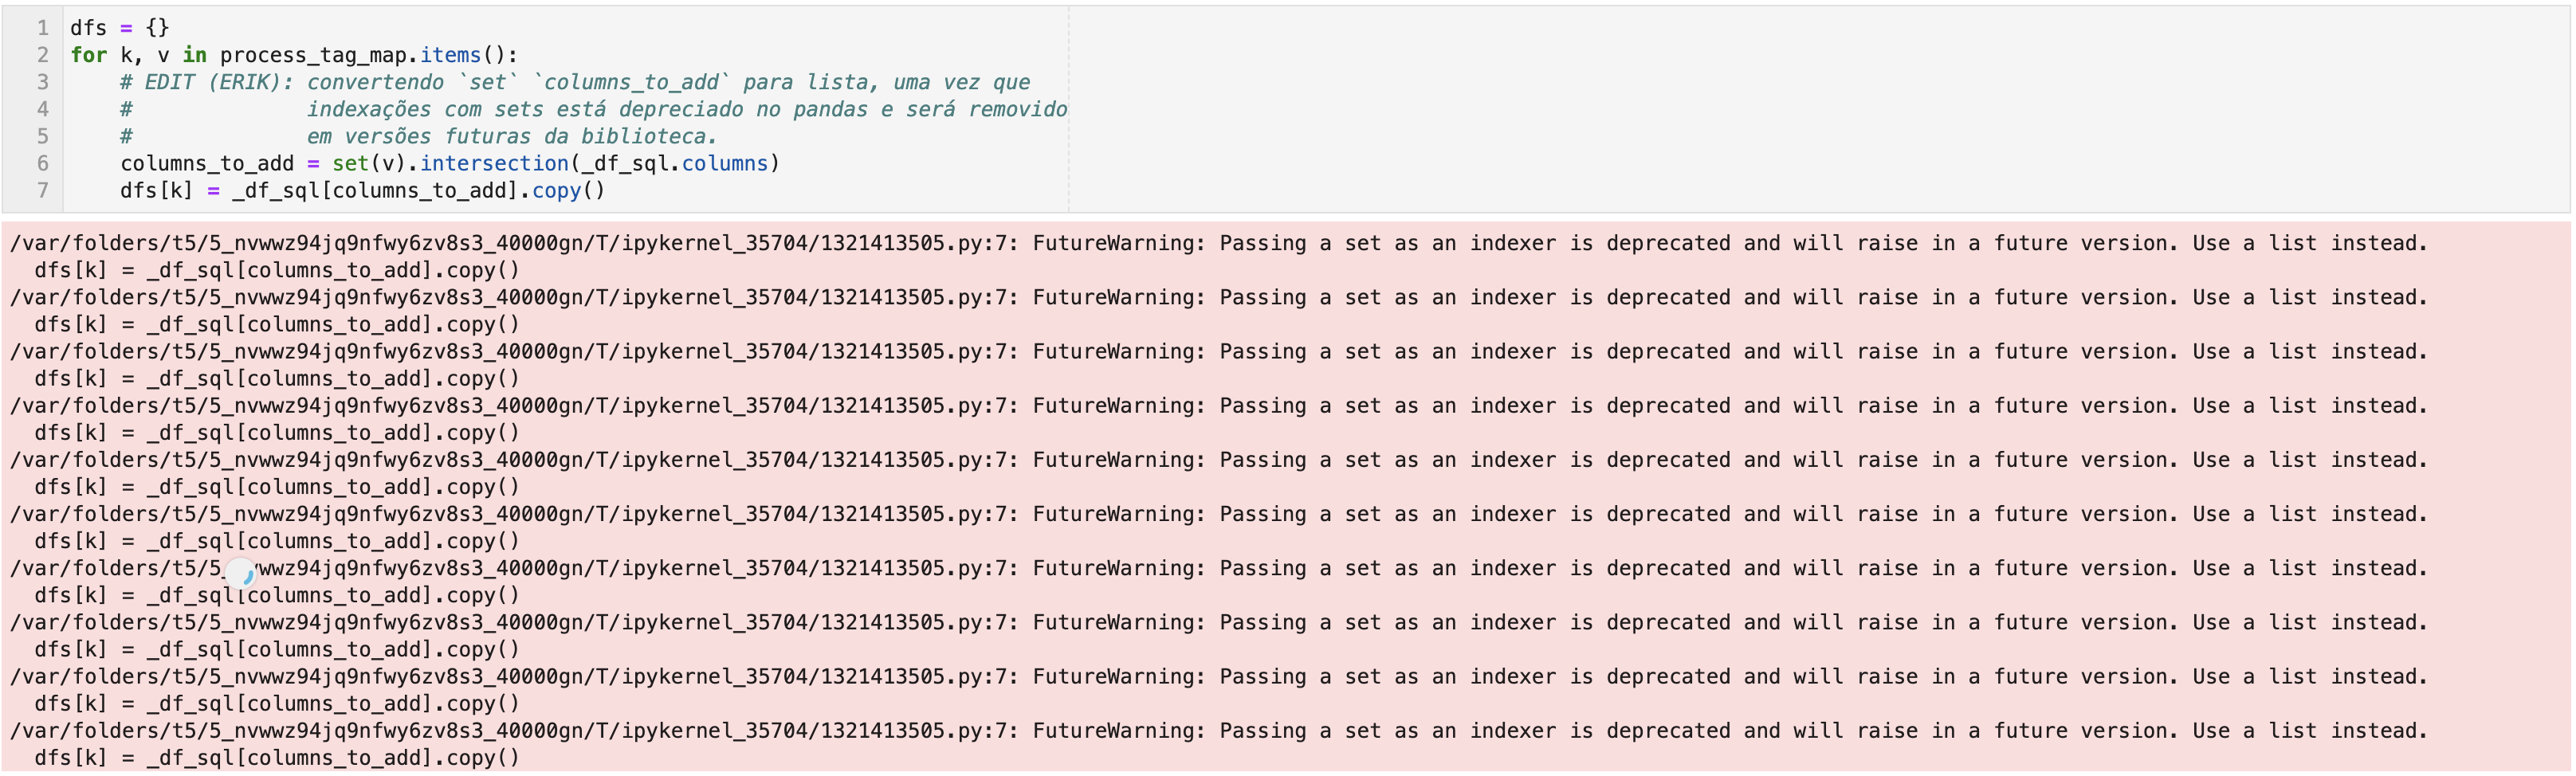

**Código corrigido:**

<!-- 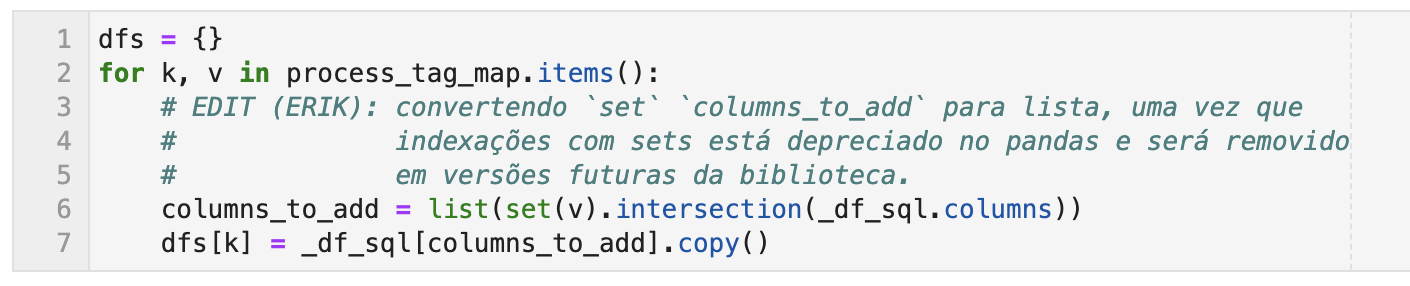 -->
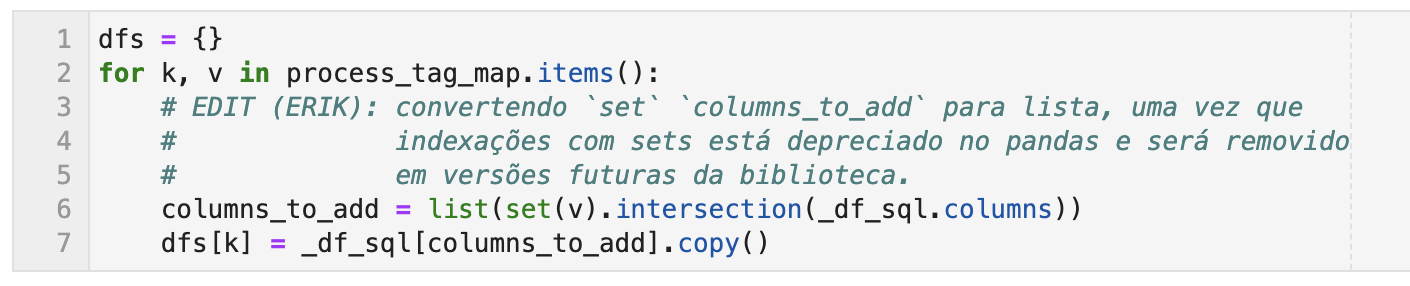

In [25]:
dfs = {}
for k, v in process_tag_map.items():
    # EDIT (ERIK): convertendo `set` `columns_to_add` para lista, uma vez que
    #              indexações com sets está depreciado no pandas e será removido
    #              em versões futuras da biblioteca.
    columns_to_add = list(set(v).intersection(_df_sql.columns))
    dfs[k] = _df_sql[columns_to_add].copy()

In [26]:
limits_temp = limits.copy()

for key, value in limits.items():
    limits[key.replace('.csv', '')] = value

In [27]:
limits[f'08 - PRENSA - SPSS - US{n_usina}'][f'PESO1_I@{n_usina:02d}PR-BW-822I-01M1'] = (0, None)
limits[f'04 - MOAGEM - SPSS - US{n_usina} - PATRICIA'][f'PESO1_I@{n_usina:02d}MO-BW-821I-02M1_DP'] = (0, None)
limits[f'04 - MOAGEM - SPSS - US{n_usina} - PATRICIA'][f'PESO1_I@{n_usina:02d}MO-BW-821I-03M1_DP'] = (0, None)
limits[f'07 - FILTRAGEM - SPSS - US{n_usina}'][f'PESO1_I@{n_usina:02d}FI-TR-827I-01M1'] = (0, None)
limits[f'08 - PRENSA - SPSS - US{n_usina}'][f'TORQ1_I@{n_usina:02d}PR-RP-822I-01M1'] = (0, None)
limits[f'08 - PRENSA - SPSS - US{n_usina}'][f'TORQ1_I@{n_usina:02d}PR-RP-822I-01M2'] = (0, None)
limits[f'11 - TRATAMENTO TERMICO - SPSS - US{n_usina}'][f'PROD_PC_I@{n_usina:02d}US'][0] = 0
limits[f'11 - TRATAMENTO TERMICO - SPSS - US{n_usina}'][f'TORQ1_I@{n_usina:02d}QU-PF-852I-02M1'] = (0, None)
limits[f'11 - TRATAMENTO TERMICO - SPSS - US{n_usina}'][f'TORQ1_I@{n_usina:02d}QU-PF-852I-04M1'] = (0, None)
limits[f'11 - TRATAMENTO TERMICO - SPSS - US{n_usina}'][f'TORQ1_I@{n_usina:02d}QU-PF-852I-05M1'] = (0, None)
limits[f'11 - TRATAMENTO TERMICO - SPSS - US{n_usina}'][f'TORQ1_I@{n_usina:02d}QU-PF-852I-08M1'] = (0, None)
limits[f'11 - TRATAMENTO TERMICO - SPSS - US{n_usina}'][f'PESO1_I@{n_usina:02d}PN-TR-860I-09M1'] = (0, None)
limits[f'11 - TRATAMENTO TERMICO - SPSS - US{n_usina}'][f'VELO2_C@{n_usina:02d}QU-FR-851I-01M1'] = (0, None)
limits[f'10 - AGLOMERACAO - SPSS - US{n_usina}'][f'PROD_PQ_Y@{n_usina:02d}US'] = (0, None)
limits[f'11 - TRATAMENTO TERMICO - SPSS - US{n_usina}'][f'PROD_PQ_Y@{n_usina:02d}US'] = (0, None)
limits[f'12 - M.AMBIENTE - SPSS - US{n_usina}'][f'VOLT1_I@{n_usina:02d}QU-PP-871I-02-PAT02'] = None

In [28]:
dfs = {key: df[~df.index.duplicated()] for key, df in dfs.items()}
# EDIT (Erik): não entendi este comentário... O código acima busca remover indexes
#              duplicados. Basicamente, se um dos valores indexadores dos dataframes
#              aparecerem 2 ou mais vezes, estes valores indexadores são removidos
#              do dataframe.
# print('isso nao faz sentido!!!')

In [30]:
# limites de pressão ajustados manualmente no json e em mocedels_v2
limits_exclude = [
    f"PRES1_I@{n_usina:02d}QU-WB-851I-01",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-02",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-04",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-05",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-06",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-07",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-08",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-09",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-10",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-11",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-12",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-13",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-21",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-27",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-31",
    *[
        value
        for i in range(1, 7)
        for value in [
            f"VOLT1_I@{n_usina:02d}QU-PP-871I-01-PAT0{i}",
            f"VOLT2_I@{n_usina:02d}QU-PP-871I-01-PAT0{i}",
        ]
    ],
]
limits_exclude

['PRES1_I@08QU-WB-851I-01',
 'PRES1_I@08QU-WB-851I-02',
 'PRES1_I@08QU-WB-851I-04',
 'PRES1_I@08QU-WB-851I-05',
 'PRES1_I@08QU-WB-851I-06',
 'PRES1_I@08QU-WB-851I-07',
 'PRES1_I@08QU-WB-851I-08',
 'PRES1_I@08QU-WB-851I-09',
 'PRES1_I@08QU-WB-851I-10',
 'PRES1_I@08QU-WB-851I-11',
 'PRES1_I@08QU-WB-851I-12',
 'PRES1_I@08QU-WB-851I-13',
 'PRES1_I@08QU-WB-851I-21',
 'PRES1_I@08QU-WB-851I-27',
 'PRES1_I@08QU-WB-851I-31',
 'VOLT1_I@08QU-PP-871I-01-PAT01',
 'VOLT1_I@08QU-PP-871I-01-PAT02',
 'VOLT1_I@08QU-PP-871I-01-PAT03',
 'VOLT1_I@08QU-PP-871I-01-PAT04',
 'VOLT1_I@08QU-PP-871I-01-PAT05',
 'VOLT1_I@08QU-PP-871I-01-PAT06',
 'VOLT2_I@08QU-PP-871I-01-PAT01',
 'VOLT2_I@08QU-PP-871I-01-PAT02',
 'VOLT2_I@08QU-PP-871I-01-PAT03',
 'VOLT2_I@08QU-PP-871I-01-PAT04',
 'VOLT2_I@08QU-PP-871I-01-PAT05',
 'VOLT2_I@08QU-PP-871I-01-PAT06']

### EDIT (Erik): Refatoração do Código

**Código Original:**

```python
for key, df in dfs.items():
    for tag in df.columns:
        if (tag in limits[key]) and (limits[key][tag] is not None) and (tag not in limits_exclude):
            lmin, lmax = limits[key][tag]
            if lmin is not None:
                df[tag] = df[tag][df[tag] >= lmin]
            if lmax is not None:
                df[tag] = df[tag][df[tag] <= lmax]
```


**Código Refatorado:**

```python
for key, df in dfs.items():
    for tag in df.columns.difference(limits_exclude):
        res = limits.get(key, {}).get(tag, None)
        if res is not None:
            lmin, lmax = res
            if lmin is not None:
                df[tag] = df[tag][df[tag] >= lmin]
            if lmax is not None:
                df[tag] = df[tag][df[tag] <= lmax]
```

In [31]:
for key, df in dfs.items():
    for tag in df.columns.difference(limits_exclude):
        res = limits.get(key, {}).get(tag, None)
        if res is not None:
            lmin, lmax = res
            if lmin is not None:
                df[tag] = df[tag][df[tag] >= lmin]
            if lmax is not None:
                df[tag] = df[tag][df[tag] <= lmax]

## Criando `datasets`

In [32]:
datasets = {}

for base in datasets_confs:
    dfs_variaveis = []
    for key, tags in base["variaveis"]:
        for tag in tags:
            if tag in dfs[key]:
                dfs_variaveis.append(dfs[key][[tag]])
            else:
                logger.error("Tag não encontrada: %s", tag)

        if len(tags) == 0:
            if key == f"10 - AGLOMERACAO - SPSS - US{n_usina}":
                dfs_variaveis.append(
                    dfs[key].drop(
                        columns=[
                            f"PROD_PQ_Y@{n_usina:02d}US",
                            f"PROD_PC_I@{n_usina:02d}US",
                        ],
                    )
                )
            else:
                dfs_variaveis.append(dfs[key])

    for qual, conf in base["targets"].items():
        if qual in ["distribuicao gran", "custo_distribuicao gran"]:
            target = dfs[conf[0]][conf[1]].dropna().sum(axis=1)
        elif qual in ["torque"]:
            target = (
                dfs[conf[0]][conf[1]].dropna().mean(axis=1).rename("TORQ1")
            )
        elif qual == "taxarp":
            target = dfs[conf[0]][conf[1]].dropna()
        else:
            target = dfs[conf[0]][[conf[1]]]

        df_target = target
        datasets[qual] = pd.concat(dfs_variaveis, axis=1)

        base_status = [
            x for x in base["status"] if x in datasets[qual].columns
        ]
        if len(set(base["status"]) - set(base_status)) > 0:
            logger.info(
                'NAO ENCONTRADOS: %s', set(base["status"]) - set(base_status)
            )
        datasets[qual]["status"] = (
            datasets[qual][base_status].max(axis=1) >= 1
        ).astype(int)

        if qual in [
            "GRAN PR",
            "SE PR",
            "SE PP",
            "abrasao",
            "compressao",
            "basicidade",
            "finos",
            "distribuicao gran",
        ]:
            for suf in ["CA", "CN", "CE", "BR"]:
                cs = [
                    c
                    for c in datasets[qual].columns
                    if c.endswith(suf) and c != "SFBR"
                ]
                if len(cs) > 0:
                    datasets[qual]["minerio_" + suf] = datasets[qual][
                        cs
                    ].sum(axis=1)
                    datasets[qual] = datasets[qual].drop(cs, axis=1)

        if qual in ["SE PP"]:
            # Aguardando tags serem integradas, pegar maior valor
            ts_torque = [
                f"TORQ1_I@{n_usina:02d}PR-RP-822I-01M2",
                f"TORQ1_I@{n_usina:02d}PR-RP-822I-01M1",
            ]
            datasets[qual]["TORQ1"] = datasets[qual][ts_torque].mean(axis=1)

        if qual == "basicidade":
            tmp = [
                f"QUIM_CAO_PP_L@{n_usina:02d}PR",
                f"QUIM_SIO2_MA_L@{n_usina:02d}PA",
                f"QUIM_CARVAO_PP_L@{n_usina:02d}PR",
                f"QUIM_CFIX_PP_L@{n_usina:02d}PR",
                f"QUIM_CAO_MA_L@{n_usina:02d}PA DP",
                f"SIO2_OCS_I@{n_usina:02d}MO-CALCARIO",
                "SFBR",
                "P DP",
                "PPC Pilha",
                "GRAN MA",
                "MGO MED",
                "minerio_CA",
                "minerio_CN",
                "AL2O3 MED",
                "MN MED",
                "SIO2 DP",
                "minerio_CE",
                "TIO2 DP",
                "TIO2 MED",
                "AL2O3 DP",
                "minerio_BR",
                "MGO DP",
                "MN DP",
                "status",
            ]
            tmp = [col for col in datasets[qual].columns if col in tmp]
            datasets[qual] = datasets[qual][tmp]
            drop_tags = [
                f"QUIM_CAO_PP_L@{n_usina:02d}PR",
                f"QUIM_CAO_MA_L@{n_usina:02d}PA DP",
                "P DP",
                "SIO2 DP",
                "TIO2 DP",
                "AL2O3 DP",
                "MGO DP",
                "MN DP",
            ]
            datasets[qual] = datasets[qual].drop(
                columns=drop_tags, errors="ignore"
            )

        if qual != "basicidade":
            if "qtde_equipamentos" in base:
                datasets[qual][base["qtde_equipamentos"][0]] = (
                    datasets[qual][base["qtde_equipamentos"][1]] >= 0.5
                ).sum(axis=1)

            drop_tags = base.get("para_remover", [])
            datasets[qual] = datasets[qual].drop(
                columns=drop_tags, errors="ignore"
            )

        logger.info("%s, %s, %s", qual, datasets[qual].shape, df_target.shape)
        datasets[qual] = pd.concat(
            [datasets[qual], df_target], axis=1, sort=True
        )

        # Tava dando erro na 'distribuicao gran' apos o `dropna()`
        datasets[qual].index.name = "Processo"


[2023-01-16 23:33:16,093 | ERROR | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/337131988.py:337131988:10] - Tag não encontrada: GRAN_-0,045_PP_L@08PR
[2023-01-16 23:33:16,096 | ERROR | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/337131988.py:337131988:10] - Tag não encontrada: H2O PP
[2023-01-16 23:33:16,204 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/337131988.py:337131988:135] - abrasao, (9482, 355), (9482, 1)
[2023-01-16 23:33:16,274 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/337131988.py:337131988:135] - compressao, (9482, 355), (9482, 1)
[2023-01-16 23:33:16,346 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/337131988.py:337131988:135] - basicidade, (9482, 4), (9482, 1)
[2023-01-16 23:33:16,412 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/337

### Modelos `temp_forno` e `temp_precipitador`

In [33]:
# Solução temporária, nao entendi de onde vem essa coluna.
# Ela surge em distribuição gran como 0, depois renomeado para vazio.
for model, df in datasets.items():
    if 0 in df.columns:
        df.drop(0, axis=1, inplace=True)
        datasets[model] = df.copy()


# Cria modelos de `temp_forno` e `temp_precipitador`
datasets["temp_forno"] = datasets["abrasao"][
    [
        f"TEMP1_I@{n_usina:02d}PN-TR-860I-01",
        f"TEMP1_I@{n_usina:02d}PN-TR-860I-02",
    ]
].copy()
datasets["temp_forno"]["Media_temp"] = _df_sql["Media_temp"]
datasets["temp_precipitador"] = datasets["abrasao"][
    [
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-01",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-02",
        f"TEMP1_I@{n_usina:02d}QU-PP-871I-03",
    ]
]
datasets["relacao gran"] = datasets["distribuicao gran"].copy()

_df_sql["rel_gran"] = (
    (
        (
            _df_sql[f"GRAN_12,5_PQ_L@{n_usina:02d}QU"]
            + _df_sql[f"GRAN_16_PQ_L@{n_usina:02d}QU"]
        )
        / (
            _df_sql[f"GRAN_10_PQ_L@{n_usina:02d}QU"]
            + _df_sql[f"GRAN_8_PQ_L@{n_usina:02d}QU"]
        )
    )
    .fillna(method="bfill")
    .fillna(method="ffill")
    .fillna(0)
)

datasets["relacao gran"] = (
    datasets["relacao gran"].join(_df_sql["rel_gran"]).copy()
)
datasets["relacao gran"] = datasets["relacao gran"][
    (_df_sql["rel_gran"] >= 0.8) & (_df_sql["rel_gran"] <= 1.2)
]

In [34]:
for key, value in datasets.items():
    if (
        ('status' in value.columns)
        and ((value['status'] == 0).sum() == value.shape[0])
    ):
        logger.info(key)
        datasets[key]['status'] = 1

[2023-01-16 23:33:17,865 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/1098746932.py:1098746932:6] - SE PP
[2023-01-16 23:33:17,870 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/1098746932.py:1098746932:6] - energia_moinho
[2023-01-16 23:33:17,871 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/1098746932.py:1098746932:6] - energia_prensa
[2023-01-16 23:33:17,874 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/1098746932.py:1098746932:6] - custo_SE PP
[2023-01-16 23:33:17,877 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/1098746932.py:1098746932:6] - torque


In [35]:
datasets_originais = datasets.copy()

for key, df in datasets_originais.items():
    n_coluns = df.shape[1]
    datasets_originais[key] = df.loc[:, ~df.columns.duplicated()]
    if n_coluns != df.shape[1]:
        logger.info(key)

datasets = datasets_originais.copy()

# logger.debug('Recupera datasets, mas `datasets_originais` já era cópia de datasets!!!!')
# EDIT (Erik): o comentário acima não está levando em conta que durante o `for..loop`,
#              o dicionário `datasets_originais` sofre alterações.
#              O código substitui `datasets` por `datasets_originais`
#              justamente por conta dessas alterações que são aplicadas dentro do `for..loop`.

In [36]:
for i in range(1, 13):
    v_rota = f'ROTA1_I@{us_sufix}PE-BD-840I-{i:02d}M1'
    v_peso = f'PESO1_I@{us_sufix}PE-BW-840I-{i:02d}M1'
    v_tm = f'GRAN_OCS_TM@{us_sufix}PE-BD-840I-{i:02d}'
    v_func = f'FUNC1_D@{us_sufix}PE-BD-840I-{i:02d}M1'
    datasets[f'rota_disco_{i}'] = datasets['finos'][[v_peso, v_tm, v_func, v_rota]].rename(columns={v_func:'status'})

In [37]:
datasets["temp_recirc"] = datasets["finos"][
    [
        f"PROD_PQ_Y@{n_usina:02d}US",
        f"ROTA1_I@{n_usina:02d}QU-PF-852I-01M1",
        f"ROTA1_I@{n_usina:02d}QU-PF-852I-07M1",
        f"ROTA1_I@{n_usina:02d}QU-PF-852I-08M1",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ01",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ03",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ04",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ05",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ06",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ07",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ08",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ09",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ10",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ11",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ12",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ13",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ14",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ15",
        f"TEMP1_I@{n_usina:02d}QU-QU-855I-GQ16",
        f"TEMP1_I@{n_usina:02d}QU-HO-851I-01",
        "status",
    ]
]

In [38]:
def fix_dens_moinho(
    datasets: Dict[str, pd.DataFrame], usina: int, moinho: int
) -> Dict[str, pd.DataFrame]:
    other_mills = sorted({1, 2, 3} - {moinho})

    drop_columns = [
        f"DENS1_C@{usina:02d}MO-MO-821I-01",
        f"DENS1_C@{usina:02d}MO-MO-821I-02",
        f"DENS1_C@{usina:02d}MO-MO-821I-03",
        f"NIVE1_I@{usina:02d}MO-SI-813I-06",
        "qtde_moinhos",
        "ProducaoPQ_Moagem",
    ]
    for mill in other_mills:
        drop_columns.extend(
            [
                f"FUNC1_D@{usina:02d}MO-MO-821I-{mill:02d}M1",
                f"NIVE1_I@{usina:02d}MO-TQ-821I-{mill:02d}",
                f"PESO1_I@{usina:02d}MO-BW-821I-{mill:02d}M1",
                f"PESO2_Q@{usina:02d}MO-TR-821I-02M1-MO{mill:02d}",
                f"POTE1_I@{usina:02d}MO-MO-821I-{mill:02d}M1",
            ]
        )

    datasets[f"dens_moinho_{moinho}"] = (
        datasets["SE PR"].drop(columns=drop_columns).copy()
    )
    datasets[f"dens_moinho_{moinho}"][f"DENS1_C@{usina:02d}MO-MO-821I-{moinho:02d}"] = (
        datasets["SE PR"][f"DENS1_C@{usina:02d}MO-MO-821I-{moinho:02d}"].copy()
    )
    datasets[f"dens_moinho_{moinho}"]["status"] = datasets[f"dens_moinho_{moinho}"][
        f"FUNC1_D@{usina:02d}MO-MO-821I-{moinho:02d}M1"
    ].copy()
    datasets[f"dens_moinho_{moinho}"].drop(
        columns=[f"FUNC1_D@{usina:02d}MO-MO-821I-{moinho:02d}M1"], inplace=True
    )
    return datasets


In [39]:
datasets = fix_dens_moinho(datasets, usina=n_usina, moinho=1)
datasets = fix_dens_moinho(datasets, usina=n_usina, moinho=2)
datasets = fix_dens_moinho(datasets, usina=n_usina, moinho=3)

In [40]:
add_model_tags(
    datasets,
    _df_sql,
    "dens_moinho_1",
    [
        f"VAZA1_I@{n_usina:02d}MO-BP-821I-01M1",
        f"VAZA1_I@{n_usina:02d}AP-BP-875I-01",
        f"DENS1_I@{n_usina:02d}AP-TQ-875I-03",
        f"VAZA1_I@{n_usina:02d}MO-BP-821I-01",
        f"VAZA1_I@{n_usina:02d}MO-MO-821I-01",
        f"VAZA1_I@{n_usina:02d}MO-TQ-821I-01",
    ],
)
add_model_tags(
    datasets,
    _df_sql,
    "dens_moinho_2",
    [
        f"VAZA1_I@{n_usina:02d}MO-BP-821I-02M1",
        f"VAZA1_I@{n_usina:02d}AP-BP-875I-01",
        f"DENS1_I@{n_usina:02d}AP-TQ-875I-03",
        f"VAZA1_I@{n_usina:02d}MO-BP-821I-02",
        f"VAZA1_I@{n_usina:02d}MO-MO-821I-02",
        f"VAZA1_I@{n_usina:02d}MO-TQ-821I-02",
    ],
)
add_model_tags(
    datasets,
    _df_sql,
    "dens_moinho_3",
    [
        f"VAZA1_I@{n_usina:02d}MO-BP-821I-03M1",
        f"VAZA1_I@{n_usina:02d}AP-BP-875I-01",
        f"DENS1_I@{n_usina:02d}AP-TQ-875I-03",
        f"VAZA1_I@{n_usina:02d}MO-BP-821I-03",
        f"VAZA1_I@{n_usina:02d}MO-MO-821I-03",
        f"VAZA1_I@{n_usina:02d}MO-TQ-821I-03",
    ],
)


In [41]:
base = datasets['gas'][datasets['gas'].columns[:-1]]

for indx, tgt in enumerate(datasets['temp_precipitador'].columns):
    modelo = "temp_precipitador_{}".format(indx + 1)
    logger.info(f'Modelo: %s | Target: %s', modelo, tgt)
    datasets[modelo] = base.copy()
    datasets[modelo][tgt] = datasets['temp_precipitador'][tgt].copy()

if 'temp_precipitador' in datasets.keys():
    del datasets['temp_precipitador']


[2023-01-16 23:33:23,721 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/1415134341.py:1415134341:5] - Modelo: temp_precipitador_1 | Target: TEMP1_I@08QU-PP-871I-01
[2023-01-16 23:33:23,724 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/1415134341.py:1415134341:5] - Modelo: temp_precipitador_2 | Target: TEMP1_I@08QU-PP-871I-02
[2023-01-16 23:33:23,727 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/1415134341.py:1415134341:5] - Modelo: temp_precipitador_3 | Target: TEMP1_I@08QU-PP-871I-03


In [42]:
base = datasets['gas'][datasets['gas'].columns[:-1]]
df_temp_forno = datasets['temp_forno']

target = 'Media_temp'
df_temp_forno = df_temp_forno[
    df_temp_forno.columns.difference(
        [
            f'TEMP1_I@{n_usina:02d}PN-TR-860I-01',
            f'TEMP1_I@{n_usina:02d}PN-TR-860I-02',
            'Media_posi',
        ]
    )
]

df_forno = pd.concat([base, df_temp_forno], axis=1)
df_forno = df_forno[[*df_forno.columns.difference([target]), target]]
df_forno['status'] = 1
datasets['temp_forno'] = df_forno

In [43]:
datasets["particulados1"] = datasets["particulados1"].drop(
    columns=[
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-02-PAT04",
        f"VOLT2_I@{n_usina:02d}QU-PP-871I-02-PAT03",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-02-PAT06",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-02-PAT05",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-02-PAT03",
        f"VOLT1_I@{n_usina:02d}QU-PP-871I-02-PAT04",
    ],
)
add_model_tags(
    datasets,
    _df_sql,
    "produtividade filtragem",
    [f"UMID_H2O_PR_L@{n_usina:02d}FI"],
)

In [44]:
datasets_teste = {}
for k, v in datasets.items():
    logger.info(k)
    datasets_teste[k] = v.rename(columns=lambda x: re.sub(r"^[\d.-]+\s*", "", str(x)))

datasets = datasets_teste.copy()

exclude_limit_tags = [f"VAZA1_I@{n_usina:02d}QU-ST-855I-01"]
for k, df in datasets.items():
    for tag in df.columns:
        if (
            ("FUNC1" not in tag)
            and ("status" not in tag)
            and (tag not in exclude_limit_tags)
        ):
            datasets[k][tag] = df[tag][
                (df[tag] >= df[tag].quantile(0.05))
                & (df[tag] <= df[tag].quantile(0.95))
            ]

    datasets[k] = datasets[k].replace(9999, np.nan)


[2023-01-16 23:33:26,042 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/167394194.py:167394194:3] - abrasao
[2023-01-16 23:33:26,050 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/167394194.py:167394194:3] - compressao
[2023-01-16 23:33:26,056 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/167394194.py:167394194:3] - basicidade
[2023-01-16 23:33:26,057 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/167394194.py:167394194:3] - finos
[2023-01-16 23:33:26,064 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/167394194.py:167394194:3] - distribuicao gran
[2023-01-16 23:33:26,070 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn/T/ipykernel_43507/167394194.py:167394194:3] - SE PP
[2023-01-16 23:33:26,072 | INFO | MainProcess | /var/folders/t5/5_nvwwz94jq9nfwy6zv8s3_40000gn

In [45]:
busca = [
    f"ABRA_-0,5_PQ_L@{n_usina:02d}QU",
    f"GRAN_-0,045_PR_L@{n_usina:02d}FI",
    f"GRAN_10_PQ_L@{n_usina:02d}QU",
    f"GRAN_12,5_PQ_L@{n_usina:02d}QU",
    f"GRAN_16_PQ_L@{n_usina:02d}QU",
    f"GRAN_8_PQ_L@{n_usina:02d}QU",
    f"PARTIC_I@{n_usina:02d}QU-CH-854I-01",
    f"PARTIC_I@{n_usina:02d}QU-CH-854I-02",
    f"PARTIC_I@{n_usina:02d}QU-CH-854I-03",
    f"QUIM_BAS2_PQ_L@{n_usina:02d}QU",
    f"QUIM_CFIX_PP_L@{n_usina:02d}PR",
    f"UMID_H2O_PR_L@{n_usina:02d}FI",
]

for tag in busca:
    for model in datasets.keys():
        if tag in datasets[model].columns:
            if tag == datasets[model].columns[-1]:
                logger.debug(tag, "->", model, "target")
            else:
                logger.debug(tag, "->", model)

gran_ocs_remover = [
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-01",
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-02",
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-03",
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-04",
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-05",
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-06",
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-07",
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-08",
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-09",
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-10",
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-11",
    f"GRAN_OCS_+16@{n_usina:02d}PE-BD-840I-12",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-01",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-02",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-03",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-04",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-05",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-06",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-07",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-08",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-09",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-10",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-11",
    f"GRAN_OCS_10-12@{n_usina:02d}PE-BD-840I-12",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-01",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-02",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-03",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-04",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-05",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-06",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-07",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-08",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-09",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-10",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-11",
    f"GRAN_OCS_10-16@{n_usina:02d}PE-BD-840I-12",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-01",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-02",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-03",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-04",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-05",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-06",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-07",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-08",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-09",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-10",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-11",
    f"GRAN_OCS_12-16@{n_usina:02d}PE-BD-840I-12",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-01",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-02",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-03",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-04",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-05",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-06",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-07",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-08",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-09",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-10",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-11",
    f"GRAN_OCS_16-18@{n_usina:02d}PE-BD-840I-12",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-01",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-02",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-03",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-04",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-05",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-06",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-07",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-08",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-09",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-10",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-11",
    f"GRAN_OCS_5-8@{n_usina:02d}PE-BD-840I-12",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-01",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-02",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-03",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-04",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-05",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-06",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-07",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-08",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-09",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-10",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-11",
    f"GRAN_OCS_8-10@{n_usina:02d}PE-BD-840I-12",
    f"GRAN_OCS_TM_Y@{n_usina:02d}PE-BD-840I",
]

tags_compressao_abrasao = [
    f"- DIF PRODUTIVI EFETIVA - VIRTUAL - CALC - US{n_usina}",
    "bentonita",
    f"CONS ESP VENT TOTAL - US{n_usina}",
    f"CONS ESPEC EE VENT - US{n_usina}",
    f"CONS1_Y@{n_usina:02d}QU-PF-852I-01M1",
    f"CONS1_Y@{n_usina:02d}QU-PF-852I-02M1",
    f"CONS1_Y@{n_usina:02d}QU-PF-852I-03M1",
    f"CONS1_Y@{n_usina:02d}QU-PF-852I-04M1",
    f"CONS1_Y@{n_usina:02d}QU-PF-852I-05M1",
    f"CONS1_Y@{n_usina:02d}QU-PF-852I-06M1",
    f"CONS1_Y@{n_usina:02d}QU-PF-852I-07M1",
    f"CONS1_Y@{n_usina:02d}QU-PF-852I-08M1",
    f"CONS1_Y@{n_usina:02d}QU-VENT",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-01M1",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-02M1",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-03M1",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-04M1",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-05M1",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-06M1",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-07M1",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-08M1",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-09M1",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-10M1",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-11M1",
    f"FUNC1_D@{n_usina:02d}PE-BD-840I-12M1",
    f"GANHO PRENSA - US{n_usina}",
    "MAIOR - MENOR ALT CAMADA",
    f"NIVE1_I@{n_usina:02d}MO-SI-813I-06",
    f"PERMEABILIDADE CV1 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV10 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV11 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV12 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV13 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV14 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV15 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV16 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV17 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV18 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV19 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV2 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV20 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV21 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV27 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV31 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV3A - CALC - US{n_usina}",
    f"PERMEABILIDADE CV3B - CALC - US{n_usina}",
    f"PERMEABILIDADE CV4 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV5 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV6 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV7 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV8 - CALC - US{n_usina}",
    f"PERMEABILIDADE CV9 - CALC - US{n_usina}",
    f"PESO1_I@{n_usina:02d}MO-BW-813I-04M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-01M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-02M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-03M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-04M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-05M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-06M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-07M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-08M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-09M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-10M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-11M1",
    f"PESO1_I@{n_usina:02d}PE-BW-840I-12M1",
    f"PESO1_I@{n_usina:02d}PE-TR-840I-28M1",
    f"PESO1_I@{n_usina:02d}PE-TR-840I-29M1",
    f"PESO1_I@{n_usina:02d}PE-TR-851I-03M1",
    f"PESO2_I@{n_usina:02d}MO-BW-813I-03M1",
    f"PESO2_I@{n_usina:02d}MO-BW-813I-04M1",
    f"POT TOTAL VENT - US{n_usina}",
    f"POTE1_I@{n_usina:02d}QU-PF-852I-01M1",
    f"POTE1_I@{n_usina:02d}QU-PF-852I-02M1",
    f"POTE1_I@{n_usina:02d}QU-PF-852I-03M1",
    f"POTE1_I@{n_usina:02d}QU-PF-852I-04M1",
    f"POTE1_I@{n_usina:02d}QU-PF-852I-05M1",
    f"POTE1_I@{n_usina:02d}QU-PF-852I-06M1",
    f"POTE1_I@{n_usina:02d}QU-PF-852I-07M1",
    f"POTE1_I@{n_usina:02d}QU-PF-852I-08M1",
    f"PRES1_I@{n_usina:02d}QU-DU-851I-01",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-21",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-27",
    f"PRES1_I@{n_usina:02d}QU-WB-851I-31",
    f"PRES1_OCS_S@{n_usina:02d}QU-PF-852I-04M1",
    f"PROD_PC_I@{n_usina:02d}US",
    f"PROD1_OCS_D@{n_usina:02d}PE-BW-840I",
    f"PROD1_OCS_S@{n_usina:02d}PE-BW-840I",
    f"PV TEMP GQ3-16-MED - US{n_usina}",
    "qtde_discos",
    f"QUIM_CARVAO_PP_L@{n_usina:02d}PR",
    f"RETO1_Y@{n_usina:02d}PE",
    f"ROTA1_I@{n_usina:02d}QU-PF-852I-01M1",
    f"ROTA1_I@{n_usina:02d}QU-PF-852I-02M1",
    f"ROTA1_I@{n_usina:02d}QU-PF-852I-03M1",
    f"ROTA1_I@{n_usina:02d}QU-PF-852I-04M1",
    f"ROTA1_I@{n_usina:02d}QU-PF-852I-05M1",
    f"ROTA1_I@{n_usina:02d}QU-PF-852I-06M1",
    f"ROTA1_I@{n_usina:02d}QU-PF-852I-07M1",
    f"ROTA1_I@{n_usina:02d}QU-PF-852I-08M1",
    f"SIO2_OCS_I@{n_usina:02d}MO-CALCARIO",
    "SOMA FUNC FILTROS",
    f"TEMP1_I@{n_usina:02d}QU-PP-871I-01",
    f"TEMP1_I@{n_usina:02d}QU-PP-871I-02",
    f"TEMP1_I@{n_usina:02d}QU-PP-871I-03",
    f"TEMP2_I@{n_usina:02d}QU-HO-851I-01",
    f"TEMP2_I@{n_usina:02d}QU-PP-871I-03",
    f"TEMP3_I@{n_usina:02d}QU-HO-851I-01",
    f"TEMP5_I@{n_usina:02d}QU-PF-852I-01M1",
    f"TEMP5_I@{n_usina:02d}QU-PF-852I-02M1",
    f"TEMP5_I@{n_usina:02d}QU-PF-852I-03M1",
    f"TEMP5_I@{n_usina:02d}QU-PF-852I-04M1",
    f"TEMP5_I@{n_usina:02d}QU-PF-852I-05M1",
    f"TEMP5_I@{n_usina:02d}QU-PF-852I-07M1",
    f"TEMP5_I@{n_usina:02d}QU-PF-852I-08M1",
    f"VAZA1_I@{n_usina:02d}QU-ST-855I-01",
    f"VELO1_C@{n_usina:02d}QU-FR-851I-01M1",
]
tags_compressao_abrasao.extend(gran_ocs_remover)

In [46]:
datasets["abrasao"].drop(
    columns=tags_compressao_abrasao, inplace=True, errors="ignore"
)
datasets["compressao"].drop(
    columns=tags_compressao_abrasao, inplace=True, errors="ignore"
)

add_model_tags(
    datasets,
    _df_sql,
    "abrasao",
    [
        "soma balanca minerio misturador",
        "soma balanca bentonita misturador",
        "soma balanca retorno correia",
        "media temp pelotas",
        "media disco de pelotamento",
        "media tm",
    ],
)
add_model_tags(
    datasets,
    _df_sql,
    "compressao",
    [
        "soma balanca minerio misturador",
        "soma balanca bentonita misturador",
        "soma balanca retorno correia",
        "media temp pelotas",
        "media disco de pelotamento",
        "media tm",
    ],
)
add_model_tags(
    datasets,
    _df_sql,
    "basicidade",
    [
        f"SIO2_OCS_I@{n_usina:02d}MO-BENTONITA",
        f"SIO2_OCS_I@{n_usina:02d}MO-ANTRACITO",
        f"SIO2_OCS_I@{n_usina:02d}MO-CALCARIO",
        f"PESO1_I@{n_usina:02d}MO-BW-813I-01M1",
        "vazao_antracito",
    ],
)

add_model_tags(
    datasets,
    _df_sql,
    "cfix",
    [
        f"FUNC1_D@{n_usina:02d}AD-BR-813I-01M1",
        f"FUNC1_D@{n_usina:02d}AD-BR-813I-02M1",
        f"ROTA1_I@{n_usina:02d}AD-BR-813I-01M1",
        f"ROTA1_I@{n_usina:02d}AD-BR-813I-02M1",
        f"FUNC1_D@{n_usina:02d}PA-TR-811I-08M1",
        f"NIVE1_I@{n_usina:02d}HO-TQ-826I-03",
        f"NIVE1_I@{n_usina:02d}HO-TQ-826I-04",
        f"NIVE1_I@{n_usina:02d}HO-TQ-826I-05",
        "vazao_antracito",
    ],
)

add_model_tags(
    datasets,
    _df_sql,
    "dens_moinho_1",
    [
        f"PESO1_I@{n_usina:02d}MO-BW-813I-04M1",
        f"PESO1_I@{n_usina:02d}MO-BW-813I-03M1",
        f"PESO2_I@{n_usina:02d}MO-BW-813I-03M1",
        f"PESO2_I@{n_usina:02d}MO-BW-813I-04M1",
        f"VAZA1_I@{n_usina:02d}AP-BP-875I-01",
        f"DENS1_I@{n_usina:02d}AP-TQ-875I-03",
        f"VAZA1_I@{n_usina:02d}MO-BP-821I-01",
        f"VAZA1_I@{n_usina:02d}MO-MO-821I-01",
        f"VAZA1_I@{n_usina:02d}MO-BP-821I-01M1",
        f"VAZA1_I@{n_usina:02d}MO-TQ-821I-01",
        f"VAZA1_I@{n_usina:02d}MO-TQ-821I-01",
        "vazao_antracito",
        "bomba de retorno tanque",
    ],
)

datasets["dens_moinho_1"].drop(
    columns=[
        "antracito",
        f"NIVE1_I@{n_usina:02d}MO-SI-813I-06",
        f"PESO2_Q@{n_usina:02d}MO-TR-821I-02M1-MO01",
        f"POTE1_I@{n_usina:02d}MO-MO-821I-01M1",
        f"FUNC1_D@{n_usina:02d}AD-BR-813I-01M1",
        f"FUNC1_D@{n_usina:02d}AD-BR-813I-02M1",
        f"PESO1_I@{n_usina:02d}MO-BW-813I-01M1",
        f"NIVE1_I@{n_usina:02d}MO-TQ-821I-01",
        f"ROTA1_I@{n_usina:02d}AD-BR-813I-02M1",
        f"ROTA1_I@{n_usina:02d}AD-BR-813I-01M1",
        f"CARV1_OCS_S@{n_usina:02d}PP",
        f"SUP_SE_PR_L@{n_usina:02d}FI",
        "Consumo de Energia (base minério úmido) kWh/ton",
        "qtde_moinhos",
        "corpo_moedor_especifico",
        "ProducaoPQ_Moagem",
        "status",
        "Umidade minério de alimentação",
    ],
    inplace=True,
    errors="ignore",
)

add_model_tags(datasets, _df_sql, "dens_moinho_2", ["bomba de retorno tanque"])

datasets["dens_moinho_2"].drop(
    columns=[
        "antracito",
        "Consumo de Energia (base minério úmido) kWh/ton",
        "corpo_moedor_especifico",
        f"FUNC1_D@{n_usina:02d}AD-BR-813I-01M1",
        f"FUNC1_D@{n_usina:02d}AD-BR-813I-02M1",
        f"PESO1_I@{n_usina:02d}MO-BW-813I-01M1",
        f"ROTA1_I@{n_usina:02d}AD-BR-813I-01M1",
        f"ROTA1_I@{n_usina:02d}AD-BR-813I-02M1",
        f"SUP_SE_PR_L@{n_usina:02d}FI",
        "status",
    ],
    inplace=True,
    errors="ignore",
)
add_model_tags(datasets, _df_sql, "dens_moinho_3", ["bomba de retorno tanque"])

datasets["dens_moinho_3"].drop(
    columns=[
        "antracito",
        f"CARV1_OCS_S@{n_usina:02d}PP",
        "Consumo de Energia (base minério úmido) kWh/ton",
        "corpo_moedor_especifico",
        f"FUNC1_D@{n_usina:02d}AD-BR-813I-01M1",
        f"FUNC1_D@{n_usina:02d}AD-BR-813I-02M1",
        f"PESO1_I@{n_usina:02d}MO-BW-813I-01M1",
        f"ROTA1_I@{n_usina:02d}AD-BR-813I-01M1",
        f"ROTA1_I@{n_usina:02d}AD-BR-813I-02M1",
        f"SUP_SE_PR_L@{n_usina:02d}FI",
        "status",
    ],
    inplace=True,
    errors="ignore",
)


In [47]:
datasets["energia_forno"].drop(
    columns=[f"PROD_PQ_Y@{n_usina:02d}US", "status", "ProducaoPQ_Moagem"],
    inplace=True,
    errors="ignore",
)
datasets["energia_prensa"].drop(
    columns=[
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-01M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-02M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-03M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-04M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-05M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-06M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-07M1",
        f"CONS1_Y@{n_usina:02d}QU-PF-852I-08M1",
    ],
    inplace=True,
    errors="ignore",
)

datasets.pop("finos", None)
print(*datasets.keys(), sep="\n")

datasets["finos"] = datasets["abrasao"].copy()
add_model_tags(datasets, _df_sql, "finos", [f"GRAN_-5_PQ_L@{n_usina:02d}QU"])
add_model_tags(
    datasets,
    _df_sql,
    "produtividade filtragem",
    ["media de densidade", "mediana de rotacao"],
)

abrasao
compressao
basicidade
distribuicao gran
SE PP
GRAN PR
SE PR
particulados1
particulados2
particulados3
gas
energia_moinho
energia_prensa
energia_forno
custo_abrasao
custo_compressao
custo_distribuicao gran
custo_SE PP
custo_GRAN PR
custo_SE PR
umidade
produtividade filtragem
torque
cfix
taxarp
temp_forno
relacao gran
rota_disco_1
rota_disco_2
rota_disco_3
rota_disco_4
rota_disco_5
rota_disco_6
rota_disco_7
rota_disco_8
rota_disco_9
rota_disco_10
rota_disco_11
rota_disco_12
temp_recirc
dens_moinho_1
dens_moinho_2
dens_moinho_3
temp_precipitador_1
temp_precipitador_2
temp_precipitador_3


In [48]:
datasets.pop('relacao gran', None)
print(*datasets.keys(), sep='\n')

abrasao
compressao
basicidade
distribuicao gran
SE PP
GRAN PR
SE PR
particulados1
particulados2
particulados3
gas
energia_moinho
energia_prensa
energia_forno
custo_abrasao
custo_compressao
custo_distribuicao gran
custo_SE PP
custo_GRAN PR
custo_SE PR
umidade
produtividade filtragem
torque
cfix
taxarp
temp_forno
rota_disco_1
rota_disco_2
rota_disco_3
rota_disco_4
rota_disco_5
rota_disco_6
rota_disco_7
rota_disco_8
rota_disco_9
rota_disco_10
rota_disco_11
rota_disco_12
temp_recirc
dens_moinho_1
dens_moinho_2
dens_moinho_3
temp_precipitador_1
temp_precipitador_2
temp_precipitador_3
finos


In [49]:
add_model_tags(datasets, _df_sql, "relacao gran", ["rel_gran"])
add_model_tags(
    datasets,
    _df_sql,
    "taxarp",
    ["media disco de pelotamento", "media alimentacao do disco", "media tm"],
)
add_model_tags(
    datasets,
    _df_sql,
    "produtividade filtragem",
    ["media de densidade", "mediana de rotacao"],
)

In [50]:
modelos_remover = [
    "temp_precipitador_1",
    "temp_precipitador_2",
    "temp_precipitador_3",
    "particulados1",
    "particulados2",
    "particulados3",
    "custo_abrasao",
    "custo_compressao",
    "custo_distribuicao gran",
    "custo_SE PP",
    "custo_GRAN PR",
    "custo_SE PR",
    "distribuicao gran",
]

for model in modelos_remover:
    datasets.pop(model, None)

print(*datasets.keys(), sep="\n")

modelos_rota = [
    "GRAN PR",
    "relacao gran",
    "rota_disco_1",
    "rota_disco_2",
    "rota_disco_3",
    "rota_disco_4",
    "rota_disco_5",
    "rota_disco_6",
    "rota_disco_7",
    "rota_disco_8",
    "rota_disco_9",
    "rota_disco_10",
    "rota_disco_11",
    "rota_disco_12",
    "finos",
]
targets_rota = [
    "rel_gran",
    f"GRAN_-0,045_PR_L@{n_usina:02d}FI",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-01",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-02",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-03",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-04",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-05",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-06",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-07",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-08",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-09",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-10",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-11",
    f"GRAN_OCS_TM@{n_usina:02d}PE-BD-840I-12",
    f"GRAN_-5_PQ_L@{n_usina:02d}QU",
]

if not len(modelos_rota) == len(targets_rota):
    raise ValueError(
        f"`modelos_rota` ({len(modelos_rota):,}) "
        f"and `targets_rota` ({len(targets_rota):,}) have different lengths."
    )

for model, target in list(zip(modelos_rota, targets_rota)):
    if model.startswith("rota"):
        continue
    cols = datasets[model].columns.to_list()
    cols.remove(target)
    datasets[model] = datasets[model][cols + [target]]


abrasao
compressao
basicidade
SE PP
GRAN PR
SE PR
gas
energia_moinho
energia_prensa
energia_forno
umidade
produtividade filtragem
torque
cfix
taxarp
temp_forno
rota_disco_1
rota_disco_2
rota_disco_3
rota_disco_4
rota_disco_5
rota_disco_6
rota_disco_7
rota_disco_8
rota_disco_9
rota_disco_10
rota_disco_11
rota_disco_12
temp_recirc
dens_moinho_1
dens_moinho_2
dens_moinho_3
finos
relacao gran


In [51]:
bad_names = {'%CF. ANT': '%CF_ANT'}
_df_sql.rename(columns=bad_names, inplace=True)

for model, df in datasets.items():
    datasets[model] = df.rename(bad_names, axis=1)


## Salvando Outputs

Iremos criar uma pasta chamada `tmp/us8` para armazenar os resultados:

- **`'datasets.joblib'`:** dicionário de dataframes a serem utilizados durante o treino dos modelos.
- **`'df_sql.joblib'`:** dataframe processado com os valores das tags.
- **`'df_sql_raw.joblib'`:** dataframe original com os valores originais das tags.

In [52]:
data_path = Path(f'./Outputs/{solver_path}')  # ./outputs/us8/

# Cria os path definido acima, caso ele não exista.
data_path.mkdir(exist_ok=True, parents=True)

# Definindo os caminhos dos arquivos resultado do presente notebook.
data_file = data_path.joinpath('datasets.joblib')
df_sql_file = data_path.joinpath('df_sql.joblib')
df_sql_raw_file = data_path.joinpath('df_sql_raw.joblib')

# Salvando resultados
joblib.dump(datasets, data_file)
joblib.dump(_df_sql, df_sql_file)
joblib.dump(df_sql, df_sql_raw_file)

['tmp/us8/df_sql_raw.joblib']

In [55]:
with pd.ExcelWriter(data_file.with_suffix('.xlsx')) as writer:
    for name, df in datasets.items():
        df.to_excel(writer, sheet_name=name)
